In [494]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/ASD_Circuits/src')
from ASD_Circuits import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
ASD_Dir = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_Aug03/"

In [422]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)
def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES
def LoadSA2(fname, DIR, topL=50):
    fin = open(DIR+fname, 'rt')
    max_cohe, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        cohe = float(l[0])
        bias = float(l[1])
        STRs = l[2].split(",")
        if cohe > max_cohe:
            max_cohe = cohe
            max_bias = bias
            max_STRs = STRs
    return max_cohe, max_bias, max_STRs

def LoadSA3(fname, DIR, adj_mat, ProbMat1, ProbMat2, topL=100):
    fin = open(DIR+fname, 'rt')
    max_cohe, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        cohe = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
        if cohe > max_cohe:
            max_cohe = cohe
            max_bias = bias
            max_STRs = STRs
    return max_cohe, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat, ProbMat1, ProbMat2):
    COHES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        #print(row["fname"], DIR)
        try:
            fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
            #cohe, real_minbias, STRs = LoadSA2(fil, DIR)
            cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
            score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
        except:
            #print("Missing Data: {}".format(row))
            continue
        if cohe == 0:
            continue
        #COHES.append(cohe)
        COHES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return COHES, CutBias, RealBias, STRS

In [175]:
def XXXX(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    COHES, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2)
    
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF2.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    COHES.append(score)
    CutBias.append(bias)
    RealBias.append(bias)
    STRS.append(topNSTRs)    
    return COHES, CutBias, RealBias, STRS

In [350]:
InfoMat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw/ScoreMat_Distance.Entropy.csv", index_col=0)
ProbMat1 = np.exp2(-InfoMat)
ProbMat1[ProbMat1==1] = 0
ProbMat2 = 1-ProbMat1
adj_mat = pd.read_csv(ConnFil, index_col=0)

In [351]:
InfoMat_long = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw/ScoreMat_Distance.long.csv", index_col=0)
ProbMat1_long = np.exp2(-InfoMat_long)
ProbMat1_long[ProbMat1_long==1] = 0
ProbMat2_long = 1-ProbMat1_long

InfoMat_short = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw/ScoreMat_Distance.short.csv", index_col=0)
ProbMat1_short = np.exp2(-InfoMat_short)
ProbMat1_short[ProbMat1_short==1] = 0
ProbMat2_short = 1-ProbMat1_short

In [208]:
biaslim_dir = "../dat/Circuits/SA/biaslims/"
size = 50
biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])

In [209]:
ASD_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_Aug03/"
ASD_BiasDF = pd.read_csv("../dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col="STR")
COHES55, CutBias55, RealBias55, STRS55 = XXXX(ASD_BiasDF, ASD_BiasDF, biaslim_df, 50, ASD_DIR, adj_mat, ProbMat1, ProbMat2)
ASD_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})

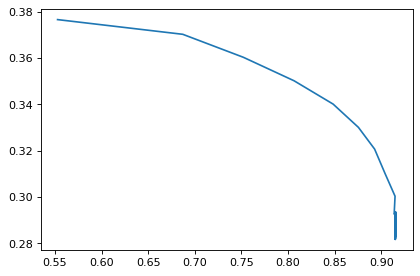

In [210]:
plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["Bias"].values)

##### xxx

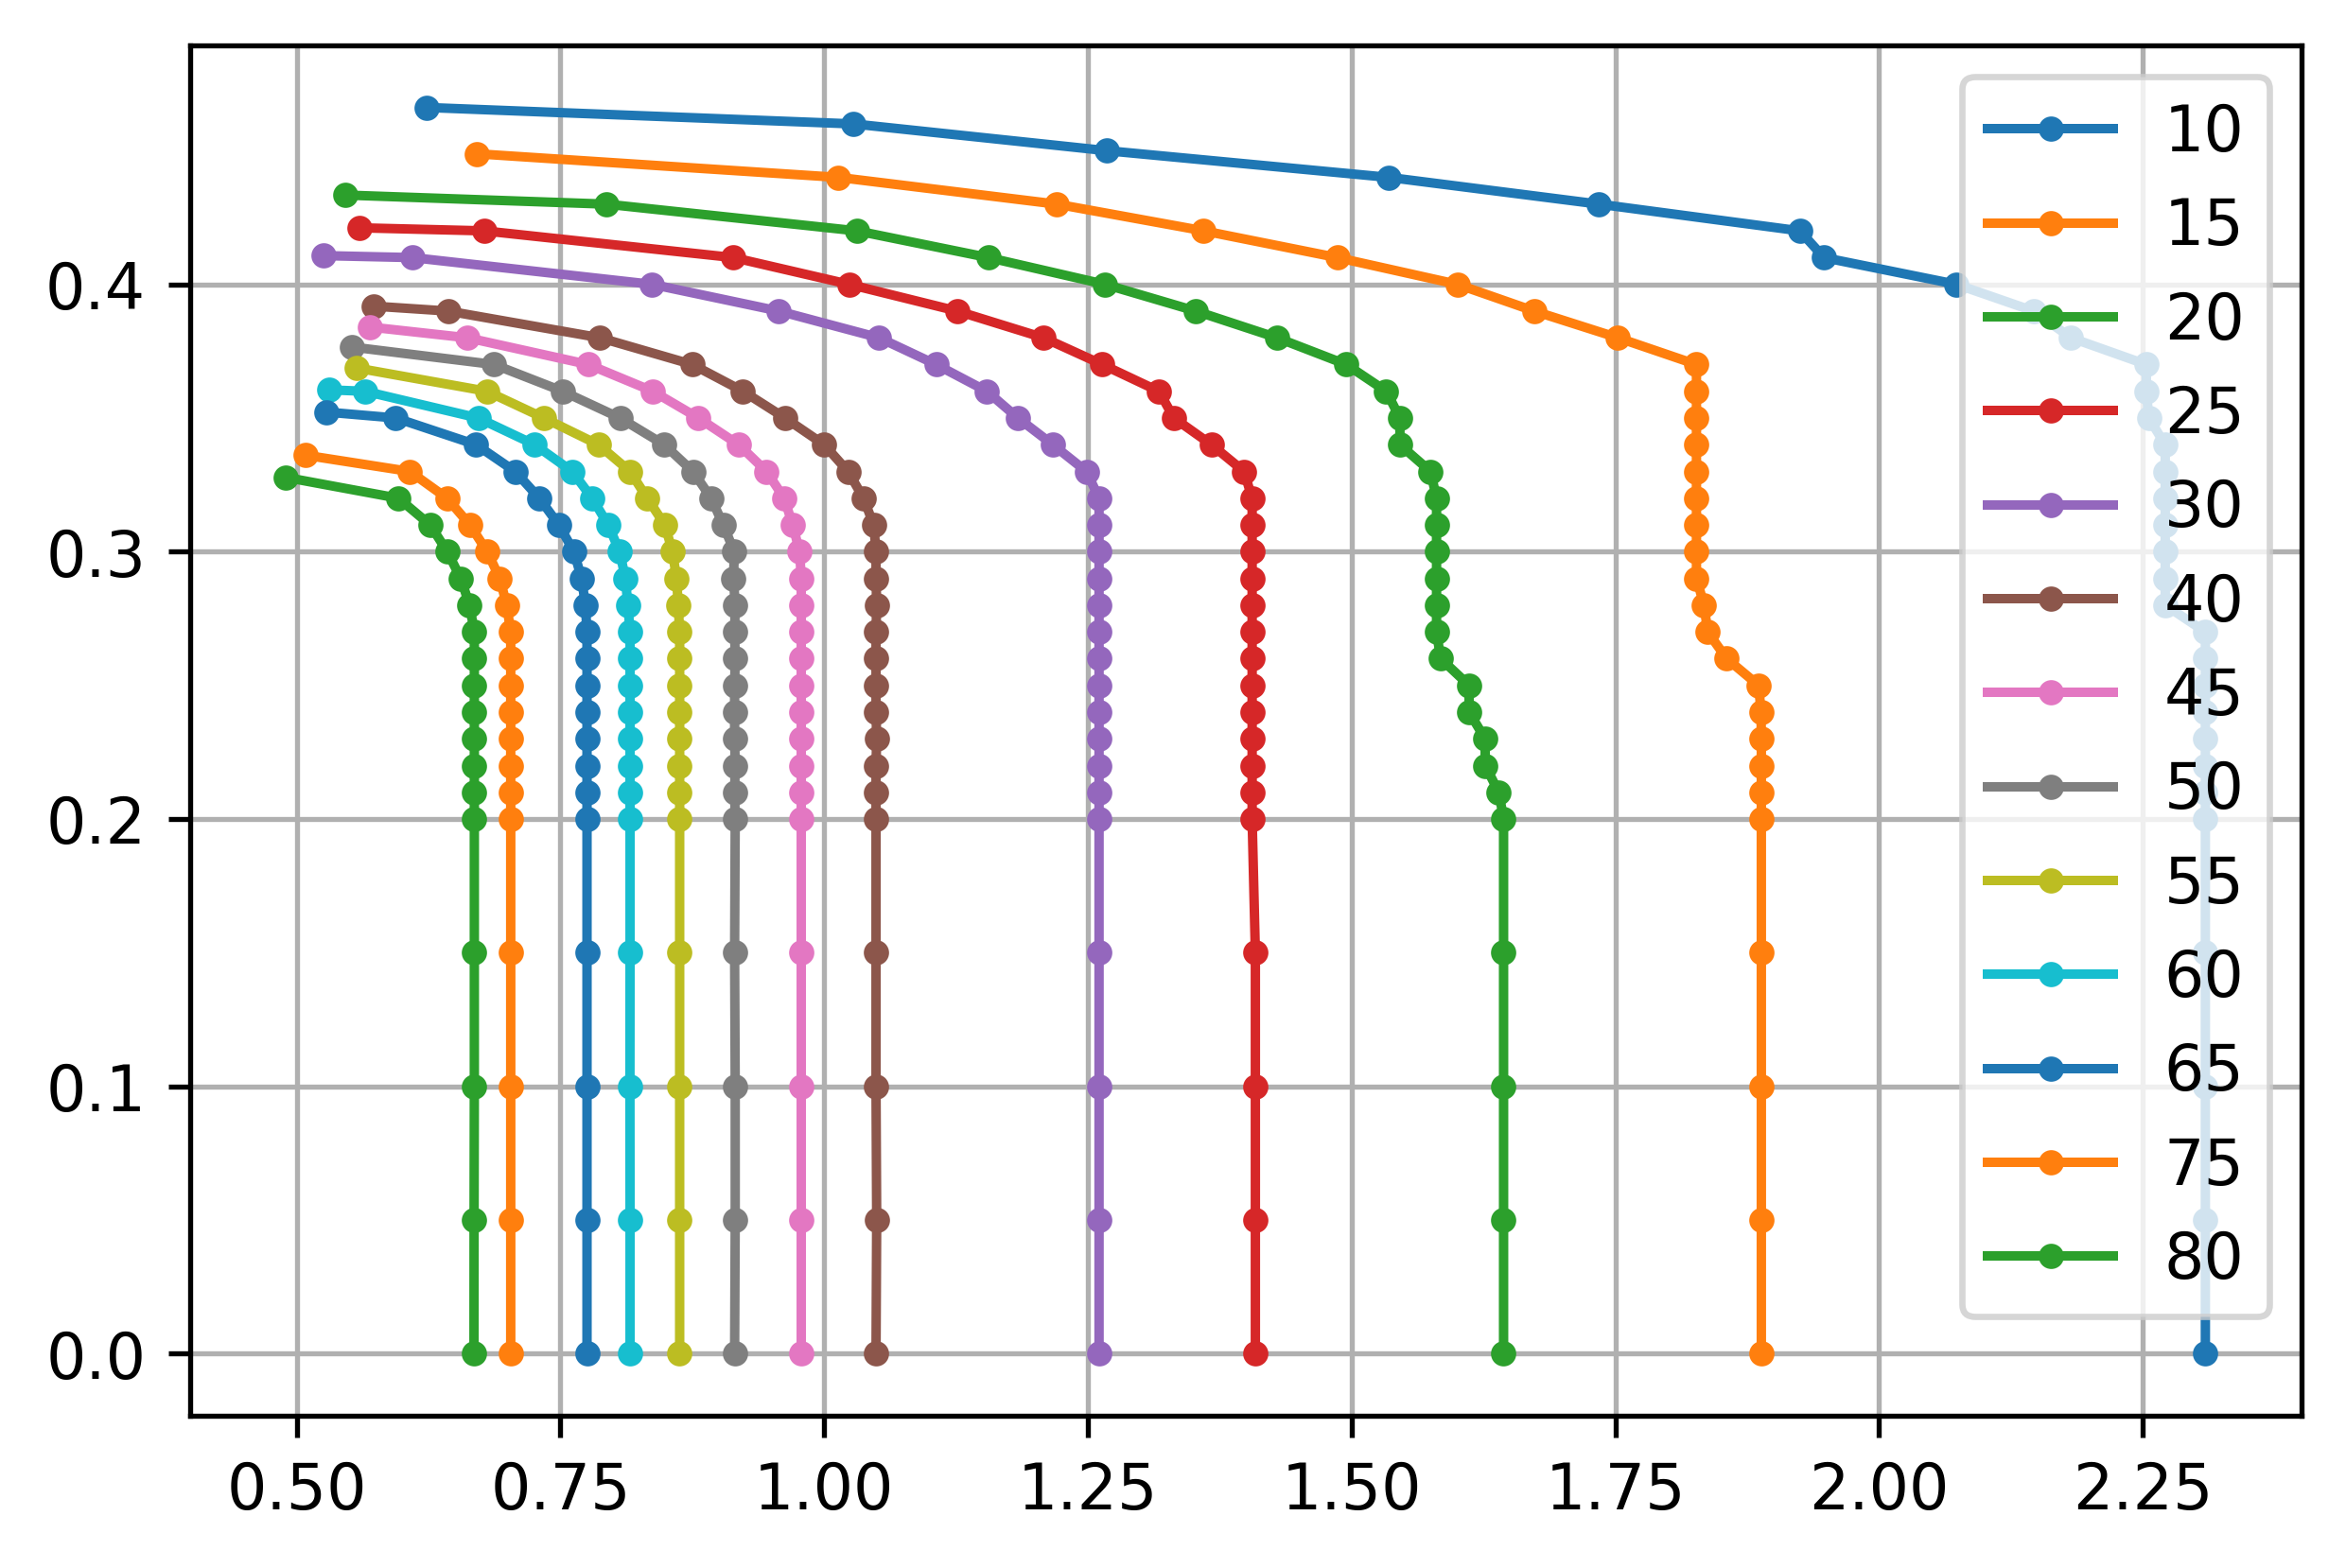

In [211]:
plt.figure(dpi=480)
for size in [10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 75, 80]:
#for size in [10]:
    biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
    COHES55, CutBias55, RealBias55, STRS55 = XXXX(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                  ASD_DIR, adj_mat, ProbMat1, ProbMat2)
    ASD_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})
    plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["minBias"].values, label=size, marker=".")
plt.grid(True)
plt.legend()

In [212]:
def GetSibAvgDat(ASD_BiasDF, Sib_BiasDir, biaslim_df, size, Sib_SADir, adj_Mat, ProbMat1, ProbMat2):
    for i in range(1,6,1):
        sib_bias_df = pd.read_csv(Sib_BiasDir + "")
        

In [213]:
plt.figure(dpi=480)
#for size in [10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 75, 80]:
for size in [10, 20, 30, 40, 50, 60, 70, 80]:
#for size in [10]:
    biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
    COHES55, CutBias55, RealBias55, STRS55 = XXXX(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                  ASD_DIR, adj_mat, ProbMat1, ProbMat2)
    ASD_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})
    Sib_DF55 = GetSibAvgDat()
    plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["minBias"].values, label=size, marker=".")
plt.grid(True)
plt.legend()

TypeError: GetSibAvgDat() missing 8 required positional arguments: 'ASD_BiasDF', 'Sib_BiasDir', 'biaslim_df', 'size', 'Sib_SADir', 'adj_Mat', 'ProbMat1', and 'ProbMat2'

<Figure size 2880x1920 with 0 Axes>

### What Fraction changed

In [267]:
biaslim_dir = "../dat/Circuits/SA/biaslims2/"
size = 46
biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

In [352]:
xx_STRs = ASD_BiasDF.head(size).index.values
score = ScoreCircuit_v7(xx_STRs, adj_mat, ProbMat1, ProbMat2)
score1 = ScoreCircuit_v7(xx_STRs, adj_mat, ProbMat1_long, ProbMat2_long)
score2 = ScoreCircuit_v7(xx_STRs, adj_mat, ProbMat1_short, ProbMat2_short)
print(score,score1,score2)
print(RegionDistributionsList(xx_STRs))

0.5746725449959333 0.5101258361793893 0.7420905709888445
Midbrain	1	Anterior_pretectal_nucleus
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Hippocampus	6	Dentate_gyrus; Field_CA2; Subiculum_ventral_part; Field_CA1; Field_CA3; Parasubiculum
Amygdalar	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Intercalated_amygdalar_nucleus
Olfactory_areas	2	Anterior_olfactory_nucleus; Dorsal_peduncular_area
Striatum	4	Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_rostral_rostroventral_part
Thalamus	8	Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_nucleus; Subparafascicular_nucleus_magnocellular_part; Mediodorsal_nucleus_of_thalamus
Isocortex	18	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular

In [355]:
cc = 0
PrevSet = set(xx_STRs)
ASD_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_Aug18_Info/"
for i, row in biaslim_df.iterrows():
    #print(row["fname"], DIR)

    fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), ASD_DIR)[0]
    cohe, real_minbias, STRs = LoadSA2(fil, ASD_DIR)
    score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
    score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
    score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
    print(row["bias"], round(real_minbias, 3), round(score, 3), round(score2, 3), round(score1, 3),
          len(set(STRs).difference(xx_STRs)))
    print("add", set(STRs).difference(PrevSet))
    print("drop", set(PrevSet).difference(STRs))
    PrevSet = set(STRs)
    cc += 1
    if cc > 16:
        break
        
    if row["bias"] == 0.37:
        List2Fil(STRs, "Circuits.Info.Size46.Bias0.37.txt")
    if row["bias"] == 0.36:
        List2Fil(STRs, "Circuits.Info.Size46.Bias0.36.txt")
        
    print()

0.38 0.38 0.63 0.797 0.561 4
add {'Orbital_area_medial_part', 'Paraventricular_nucleus_of_the_thalamus', 'Supplemental_somatosensory_area', 'Piriform_area'}
drop {'Endopiriform_nucleus_ventral_part', 'Parasubiculum', 'Subparafascicular_nucleus_magnocellular_part', 'Intercalated_amygdalar_nucleus'}

0.375 0.375 0.714 0.817 0.673 5
add {'Entorhinal_area_lateral_part', 'Basolateral_amygdalar_nucleus'}
drop {'Visceral_area', 'Supplemental_somatosensory_area'}

0.37 0.37 0.759 0.839 0.729 7
add {'Subiculum_dorsal_part', 'Anteromedial_nucleus_dorsal_part'}
drop {'Lateral_septal_nucleus_ventral_part', 'Field_CA3'}

0.365 0.365 0.792 0.844 0.772 9
add {'Central_medial_nucleus_of_the_thalamus', 'Anterior_cingulate_area_ventral_part'}
drop {'Dentate_gyrus', 'Field_CA2'}

0.36 0.36 0.822 0.859 0.808 10
add {'Primary_somatosensory_area_barrel_field', 'Taenia_tecta', 'Subparafascicular_nucleus_magnocellular_part'}
drop {'Lateral_visual_area', 'Central_medial_nucleus_of_the_thalamus', 'Field_CA1'}



In [297]:
#for size in [46]:
#for size in [10]:
size = 46
biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
COHES55, CutBias55, RealBias55, STRS55 = XXXX(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                              ASD_DIR, adj_mat, ProbMat1, ProbMat2)
ASD_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})


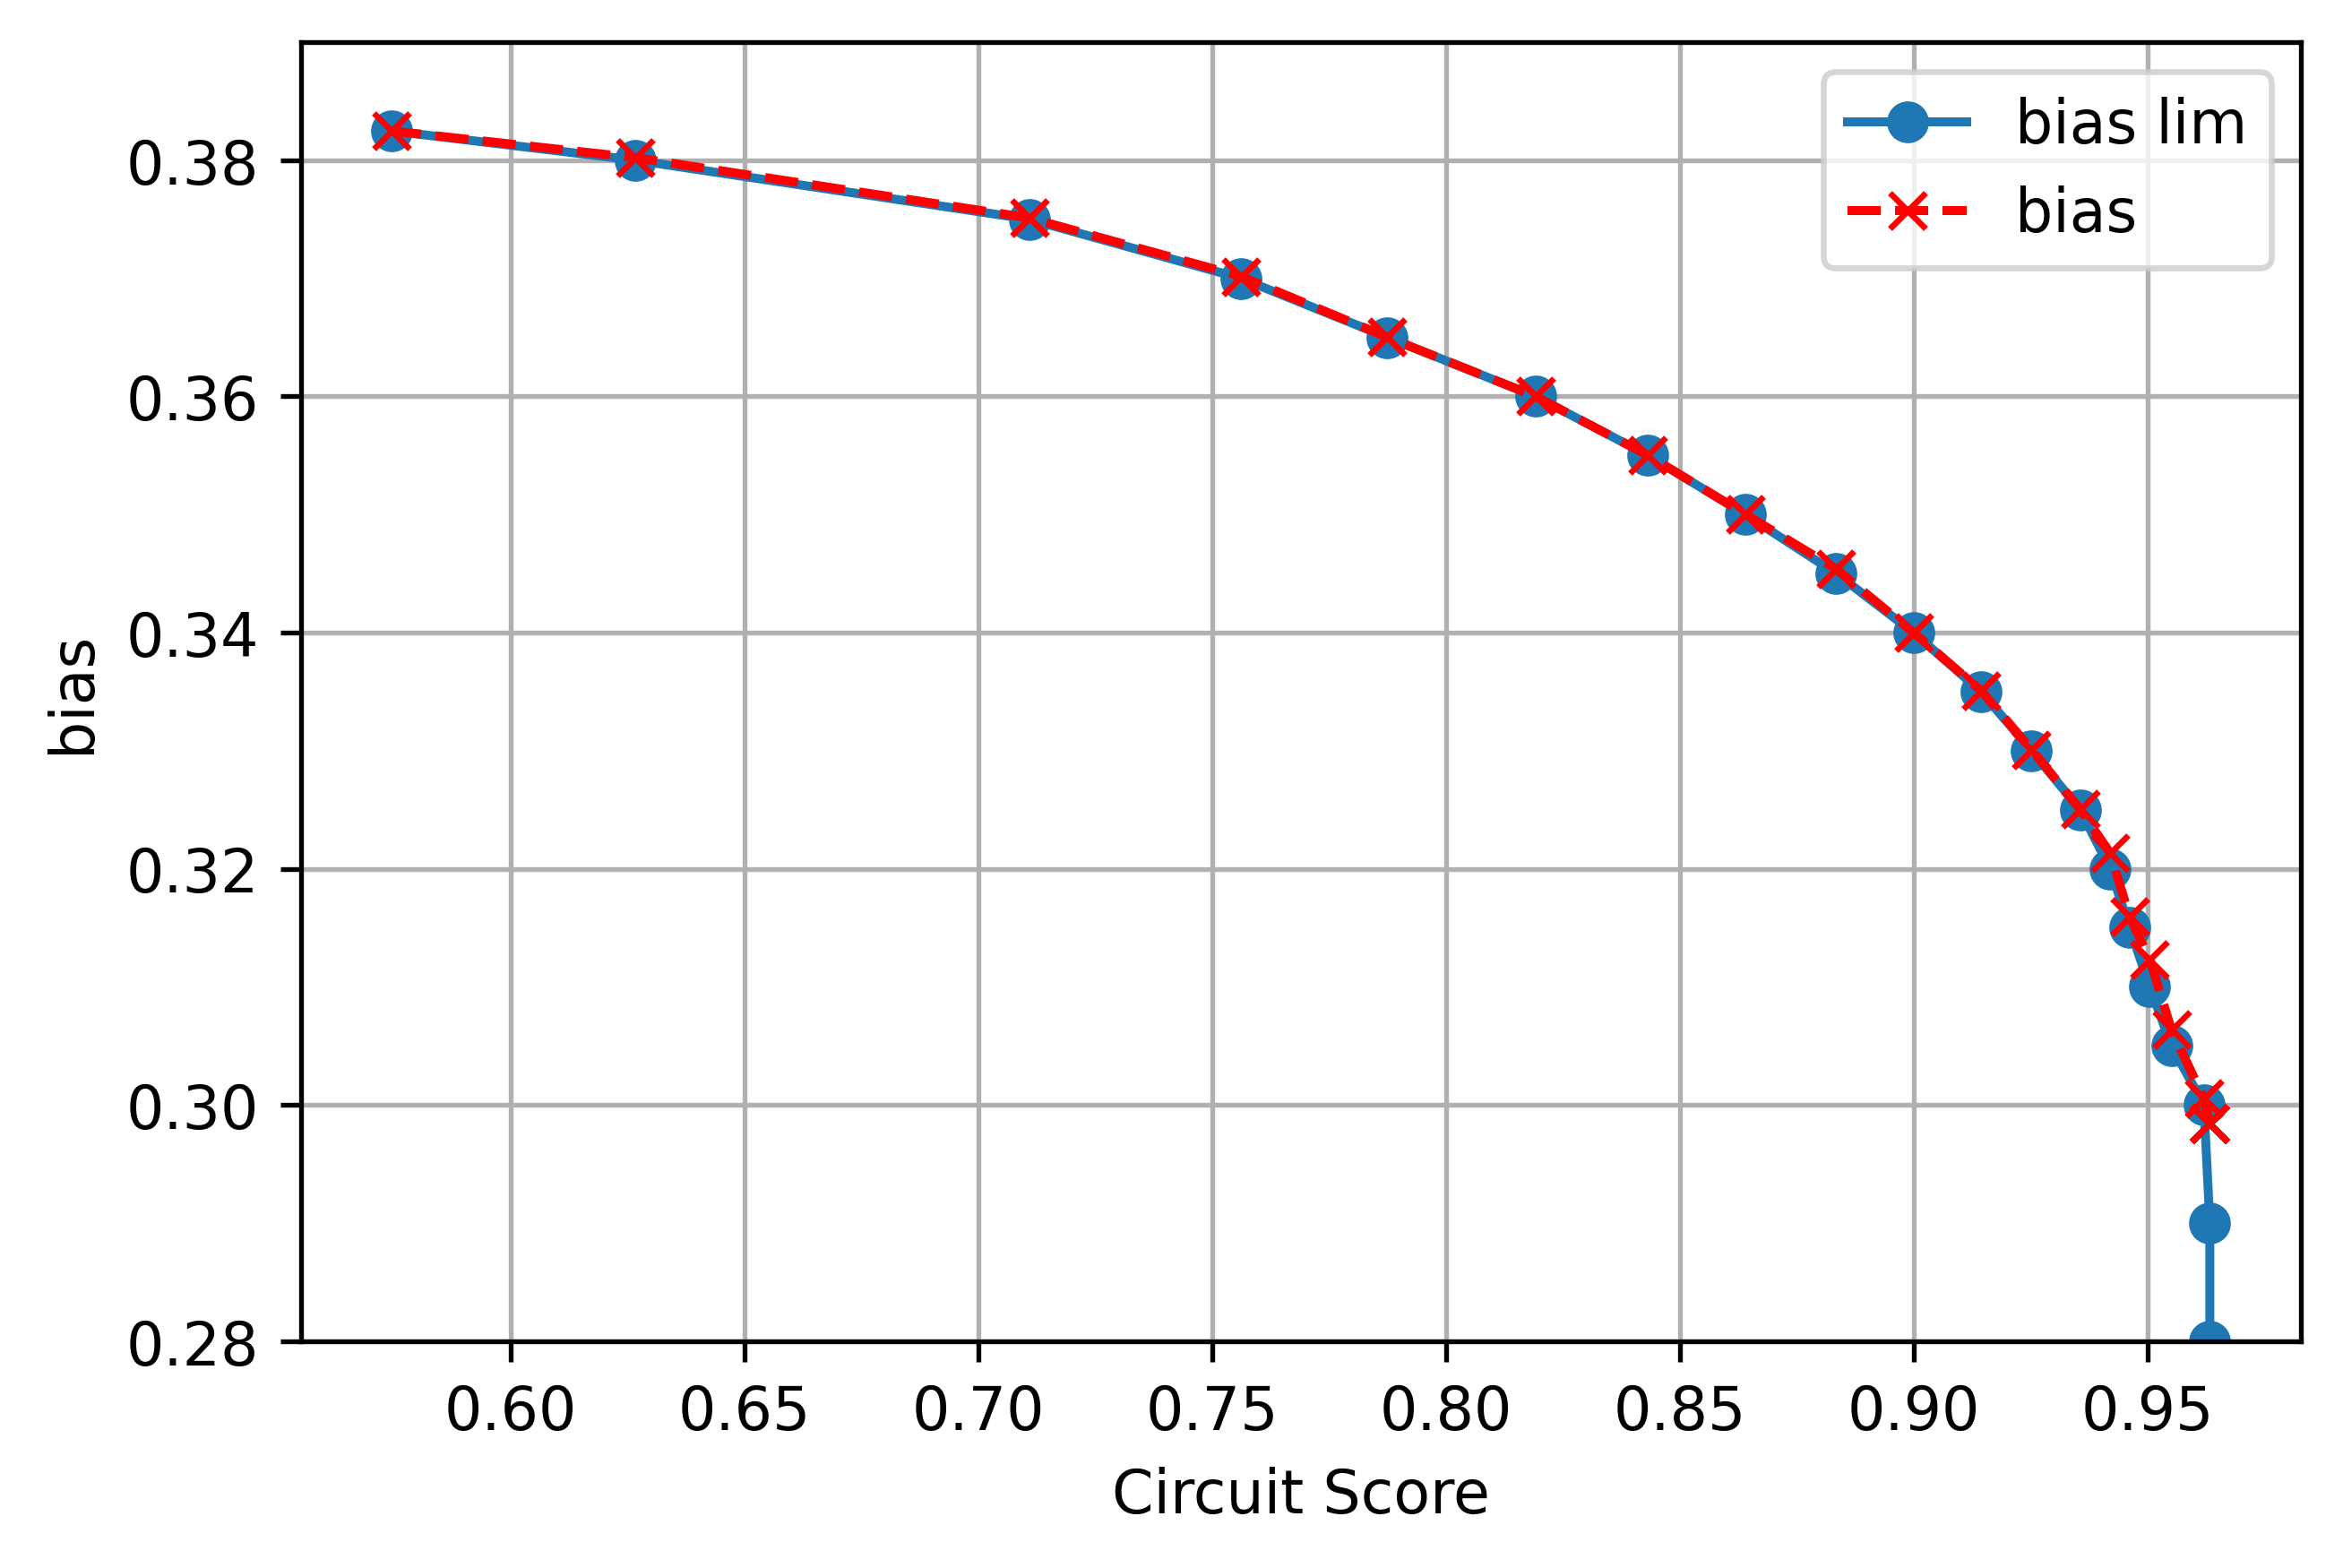

In [298]:
plt.figure(dpi=480)

plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["minBias"].values, marker="o", label="bias lim")
plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["Bias"].values, marker="x", color="red",
             ls = "--", label="bias")
plt.grid(True)
plt.ylim((0.28, 0.39))
plt.legend()
plt.xlabel("Circuit Score")
plt.ylabel("bias")
plt.savefig("../figs/ASD_Circuits.Pareto.46.pdf")

#### SA on Conn not Info

In [238]:
biaslim_dir = "../dat/Circuits/SA/biaslims/"
size = 46
biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

In [239]:
xx_STRs = ASD_BiasDF.head(size).index.values
score = ScoreCircuit_Conn(xx_STRs, adj_mat)
print(score)
print(RegionDistributionsList(xx_STRs))

0.14009661835748793
Midbrain	1	Anterior_pretectal_nucleus
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Hippocampus	6	Dentate_gyrus; Field_CA2; Subiculum_ventral_part; Field_CA1; Field_CA3; Parasubiculum
Amygdalar	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Intercalated_amygdalar_nucleus
Olfactory_areas	2	Anterior_olfactory_nucleus; Dorsal_peduncular_area
Striatum	4	Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_ventral_part; Lateral_septal_nucleus_rostral_rostroventral_part
Thalamus	8	Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_nucleus; Subparafascicular_nucleus_magnocellular_part; Mediodorsal_nucleus_of_thalamus
Isocortex	18	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Primary_m

In [240]:
cc = 0
PrevSet = set(xx_STRs)
ASD_DIR = "../dat/Circuits/SA/ASD_Pareto_Aug17_Conn/"
for i, row in biaslim_df.iterrows():
    #print(row["fname"], DIR)

    fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), ASD_DIR)[0]
    cohe, real_minbias, STRs = LoadSA2(fil, ASD_DIR)
    score = ScoreCircuit_Conn(STRs, adj_mat)
    print(row["bias"], score, len(set(STRs).difference(xx_STRs)))
    print("add", set(STRs).difference(PrevSet))
    print("drop", set(PrevSet).difference(STRs))
    PrevSet = set(STRs)
    cc += 1
    if cc > 8:
        break
    print()

0.38 0.15990338164251208 4
add {'Orbital_area_medial_part', 'Paraventricular_nucleus_of_the_thalamus', 'Supplemental_somatosensory_area', 'Piriform_area'}
drop {'Endopiriform_nucleus_ventral_part', 'Parasubiculum', 'Subparafascicular_nucleus_magnocellular_part', 'Intercalated_amygdalar_nucleus'}

0.37 0.1932367149758454 7
add {'Entorhinal_area_lateral_part', 'Taenia_tecta', 'Basolateral_amygdalar_nucleus', 'Subiculum_dorsal_part'}
drop {'Lateral_septal_nucleus_ventral_part', 'Gustatory_areas', 'Visceral_area', 'Supplemental_somatosensory_area'}

0.36 0.21159420289855072 10
add {'Primary_somatosensory_area_barrel_field', 'Gustatory_areas', 'Anterior_cingulate_area_ventral_part', 'Anteromedial_nucleus_dorsal_part'}
drop {'Dentate_gyrus', 'Field_CA2', 'Field_CA1', 'Field_CA3'}

0.35 0.22415458937198068 13
add {'Agranular_insular_area_dorsal_part', 'Ventral_medial_nucleus_of_the_thalamus', 'Posterior_complex_of_the_thalamus', 'Primary_somatosensory_area_upper_limb', 'Frontal_pole_cerebral_

In [231]:
def LoadSA4(fname, DIR, adj_mat, ProbMat1, ProbMat2, topL=100):
    fin = open(DIR+fname, 'rt')
    max_cohe, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        cohe = ScoreCircuit_Conn(STRs, adj_mat)
        if cohe > max_cohe:
            max_cohe = cohe
            max_bias = bias
            max_STRs = STRs
    return max_cohe, max_bias, max_STRs

def GetData3(params, size, DIR, adj_mat, ProbMat1, ProbMat2):
    COHES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        #print(row["fname"], DIR)
        try:
            fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
            #cohe, real_minbias, STRs = LoadSA2(fil, DIR)
            cohe, real_minbias, STRs = LoadSA4(fil, DIR, adj_mat, ProbMat1, ProbMat2)
            score = ScoreCircuit_Conn(STRs, adj_mat)
        except:
            print("Missing Data: {}".format(row))
            continue
        if cohe == 0:
            continue
        #COHES.append(cohe)
        COHES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return COHES, CutBias, RealBias, STRS
def XXXX2(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    COHES, CutBias, RealBias, STRS = GetData3(biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2)
    
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF2.head(size)["EFFECT"].mean()
    score = ScoreCircuit_Conn(topNSTRs, adj_mat)
    COHES.append(score)
    CutBias.append(bias)
    RealBias.append(bias)
    STRS.append(topNSTRs)    
    return COHES, CutBias, RealBias, STRS

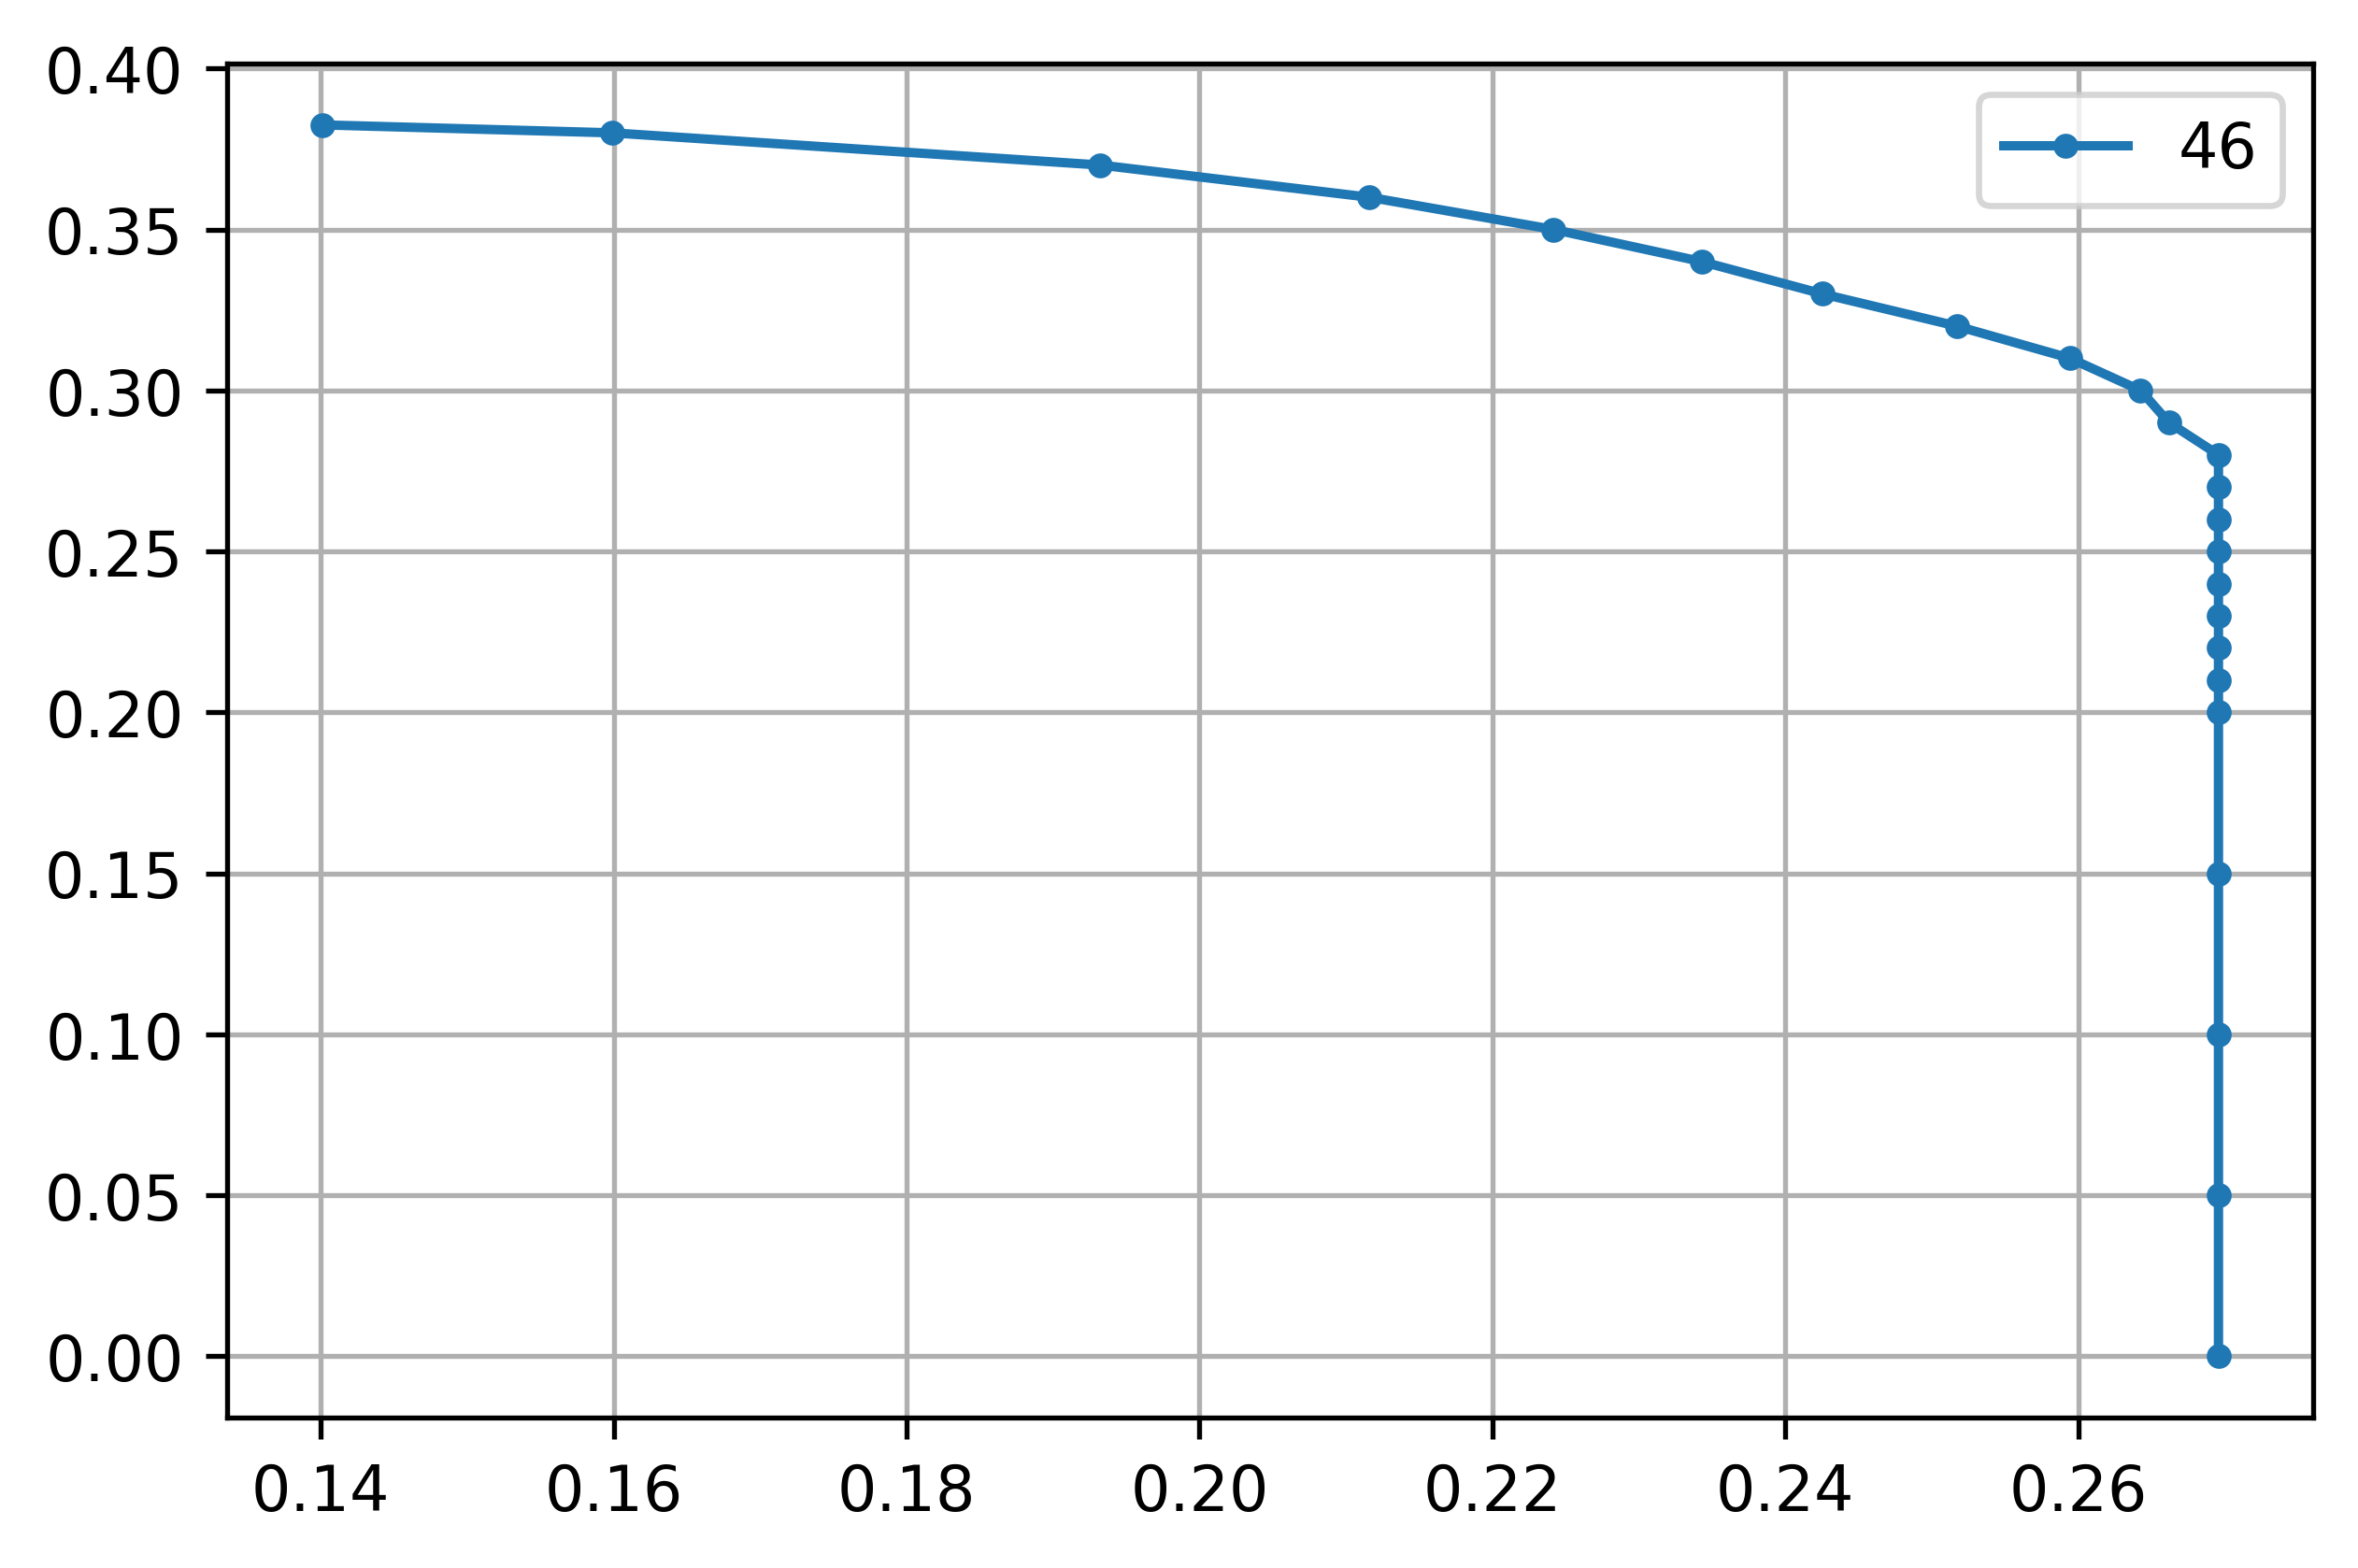

In [232]:
plt.figure(dpi=480)
for size in [46]:
#for size in [10]:
    biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
    COHES55, CutBias55, RealBias55, STRS55 = XXXX2(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                  ASD_DIR, adj_mat, ProbMat1, ProbMat2)
    ASD_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})
    plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["minBias"].values, label=size, marker=".")
plt.grid(True)
plt.legend()

##### SubSampledSibOnPlot

In [306]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)
def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES
def LoadSA3(fname, DIR, adj_mat, ProbMat1, ProbMat2, topL=100):
    fin = open(DIR+fname, 'rt')
    max_cohe, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        cohe = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
        if cohe > max_cohe:
            max_cohe = cohe
            max_bias = bias
            max_STRs = STRs
    return max_cohe, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat, ProbMat1, ProbMat2):
    COHES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        #print(row["fname"], DIR)
        try:
            fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
            #cohe, real_minbias, STRs = LoadSA2(fil, DIR)
            cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
            score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
        except:
            print("Missing Data: {}".format(row))
            continue
        if cohe == 0:
            continue
        #COHES.append(cohe)
        COHES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return COHES, CutBias, RealBias, STRS

def XXXX_cont(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    COHES, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2)
    New_RealBias = []
    for STRSET in STRS:
        xx = BiasDF.loc[STRSET, "EFFECT"].mean()
        #print(xx)
        New_RealBias.append(xx)
    #print(len(COHES), len(CutBias), len(New_RealBias), len(STRS))
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    COHES.append(score)
    CutBias.append(bias)
    New_RealBias.append(bias)
    STRS.append(topNSTRs)    
    #print(len(COHES), len(CutBias), len(New_RealBias), len(STRS))
    return COHES, CutBias, New_RealBias, STRS

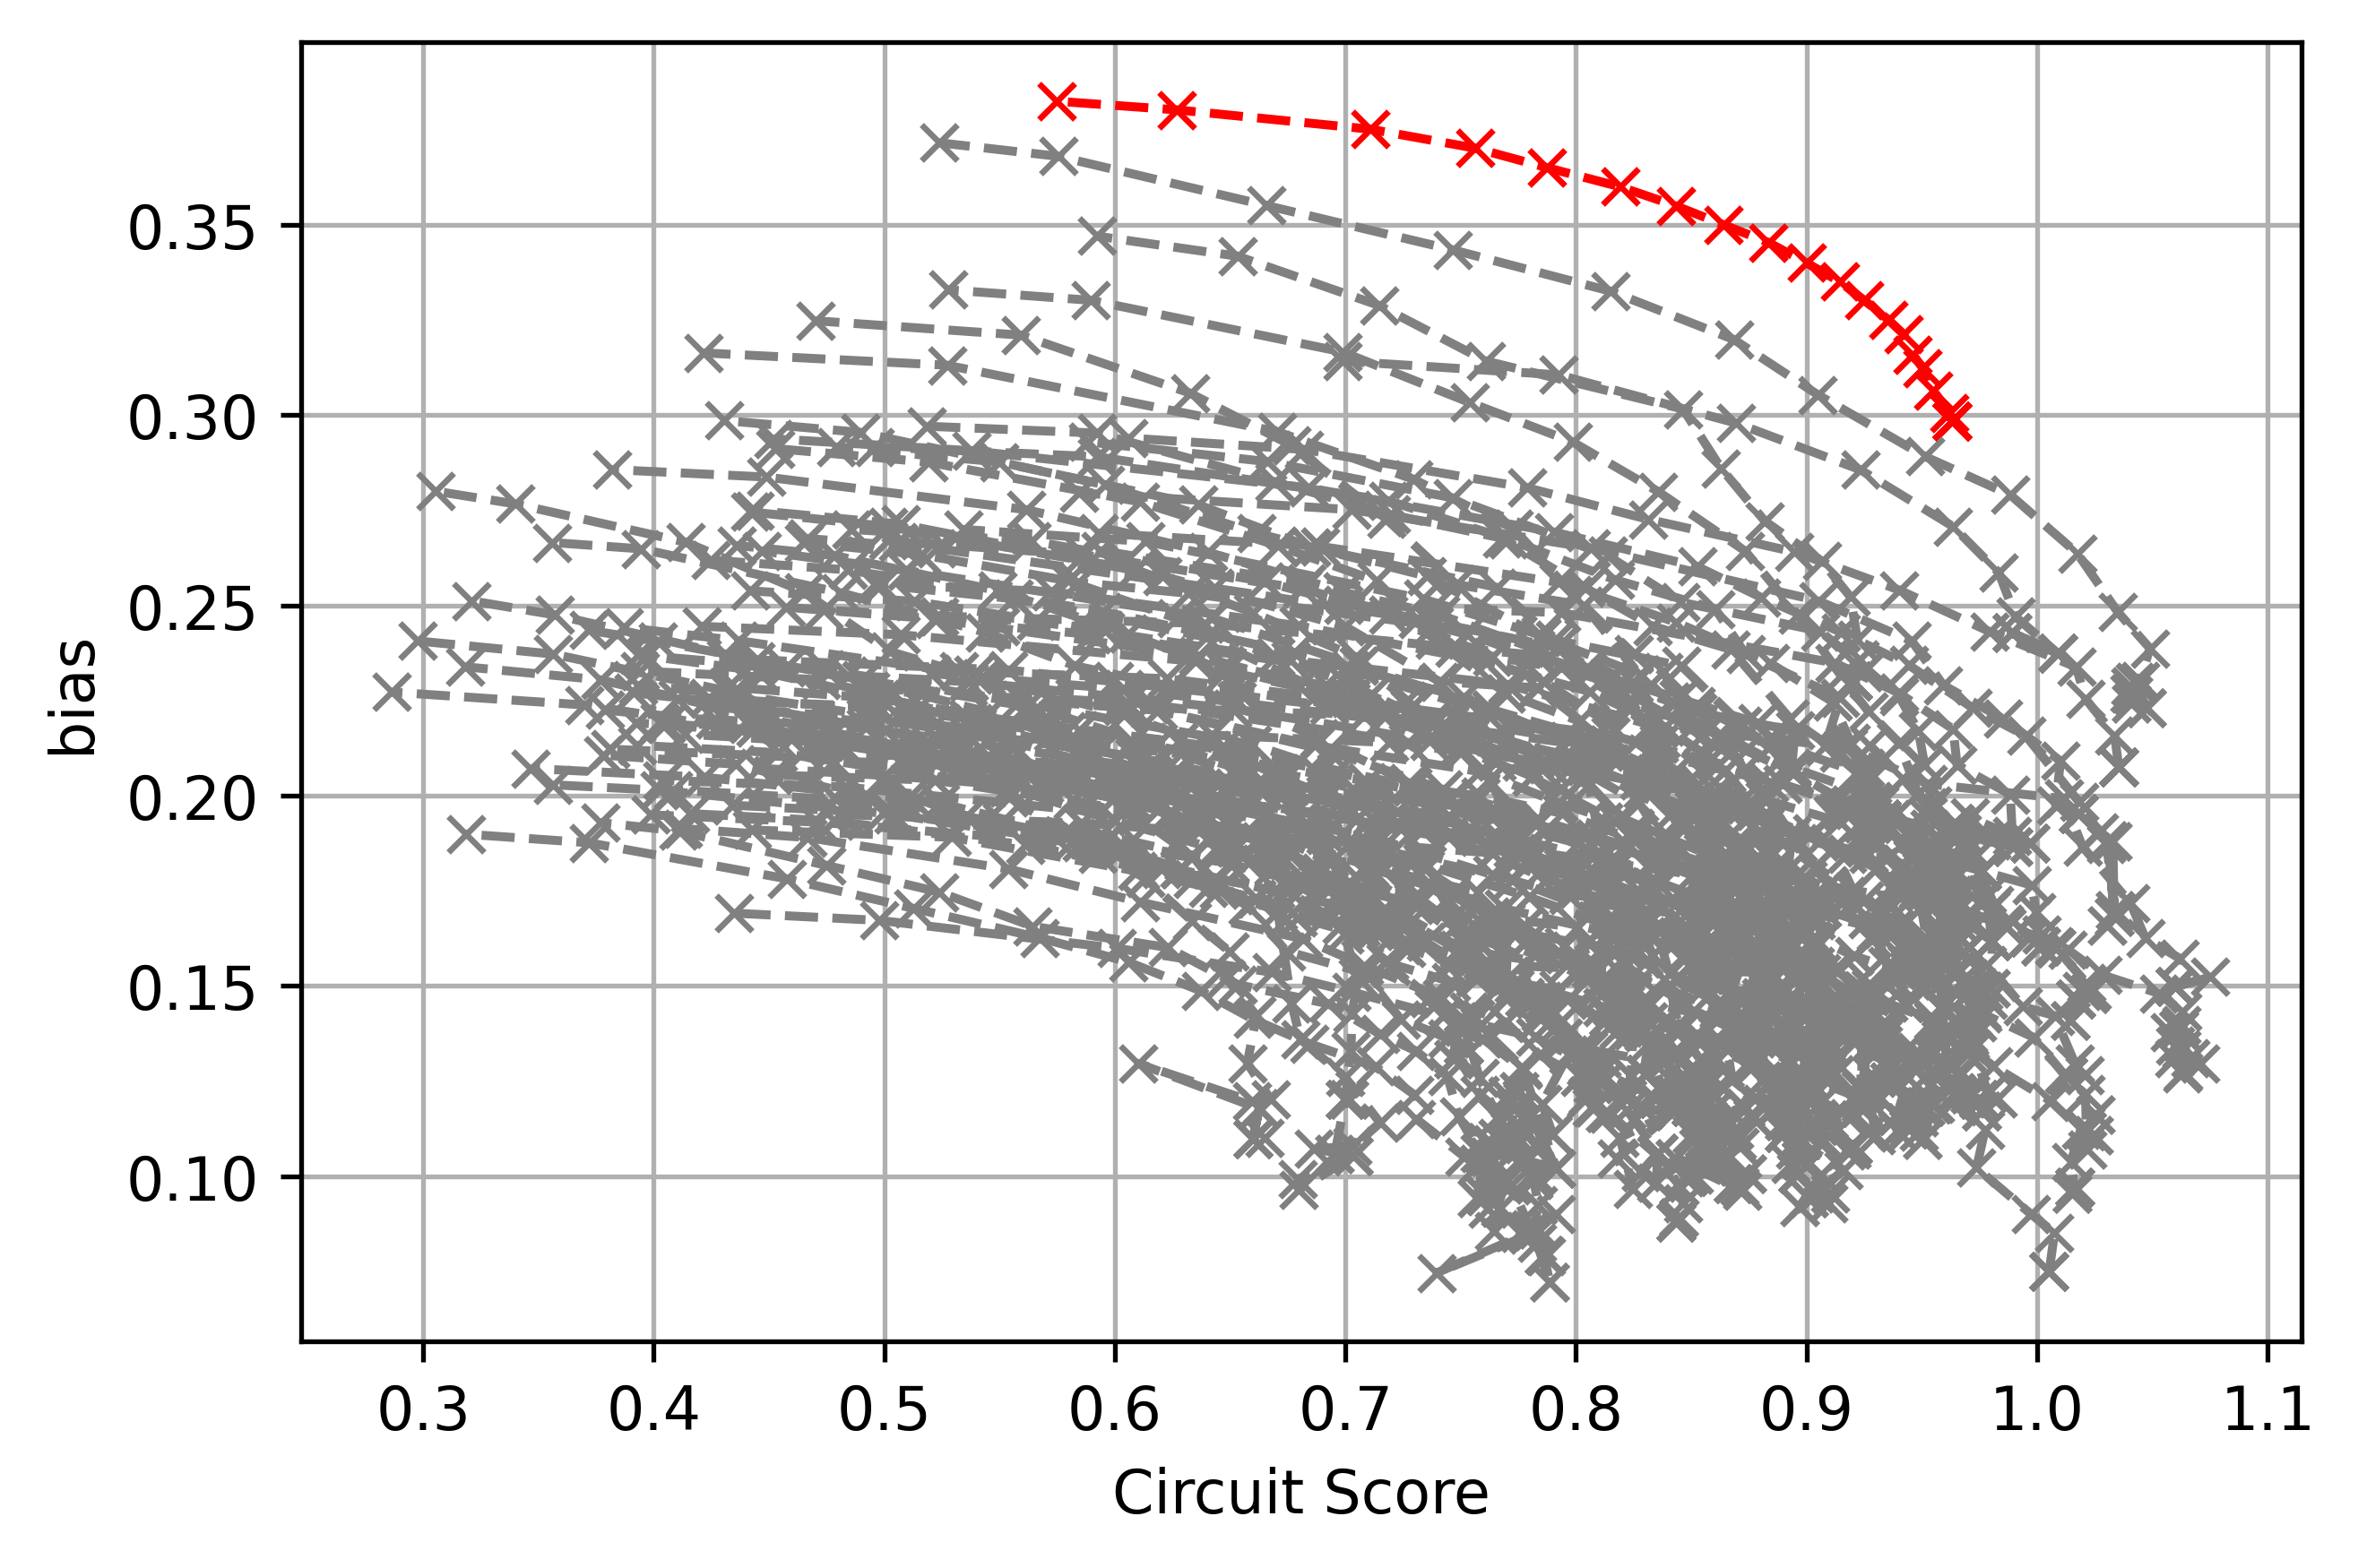

In [308]:
size = 46
biaslim_dir_cont = "../dat/Circuits/SA/biaslims/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.{}.txt".format(size), names=["size", "bias"])

plt.figure(dpi=480)
plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["Bias"].values, marker="x", color="red",
             ls = "--", label="bias")

for i in range(1,99):
    Sib_BiasDF = pd.read_csv("../dat/Unionize_bias/SubSampleSib/cont.bias.{}.{}.csv".format(1, i),
                            index_col="STR")
    ASD_cont_Dir = "../dat/Circuits/SA/SubSib_ScoreDistance_Aug17/dat_con.bias.1.{}/".format(i)
    COHES55, CutBias55, RealBias55, STRS55 = XXXX_cont(Sib_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                  ASD_cont_Dir, adj_mat, ProbMat1, ProbMat2)
    Sib_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})
    plt.plot(Sib_DF55["Cohe"].values, Sib_DF55["Bias"].values, marker="x", color="gray",
             ls = "--")
plt.grid(True)
#plt.ylim((0.28, 0.39))
#plt.legend()
plt.xlabel("Circuit Score")
plt.ylabel("bias")
plt.savefig("../figs/ASD_Circuits.Pareto.46.cont.2.pdf")

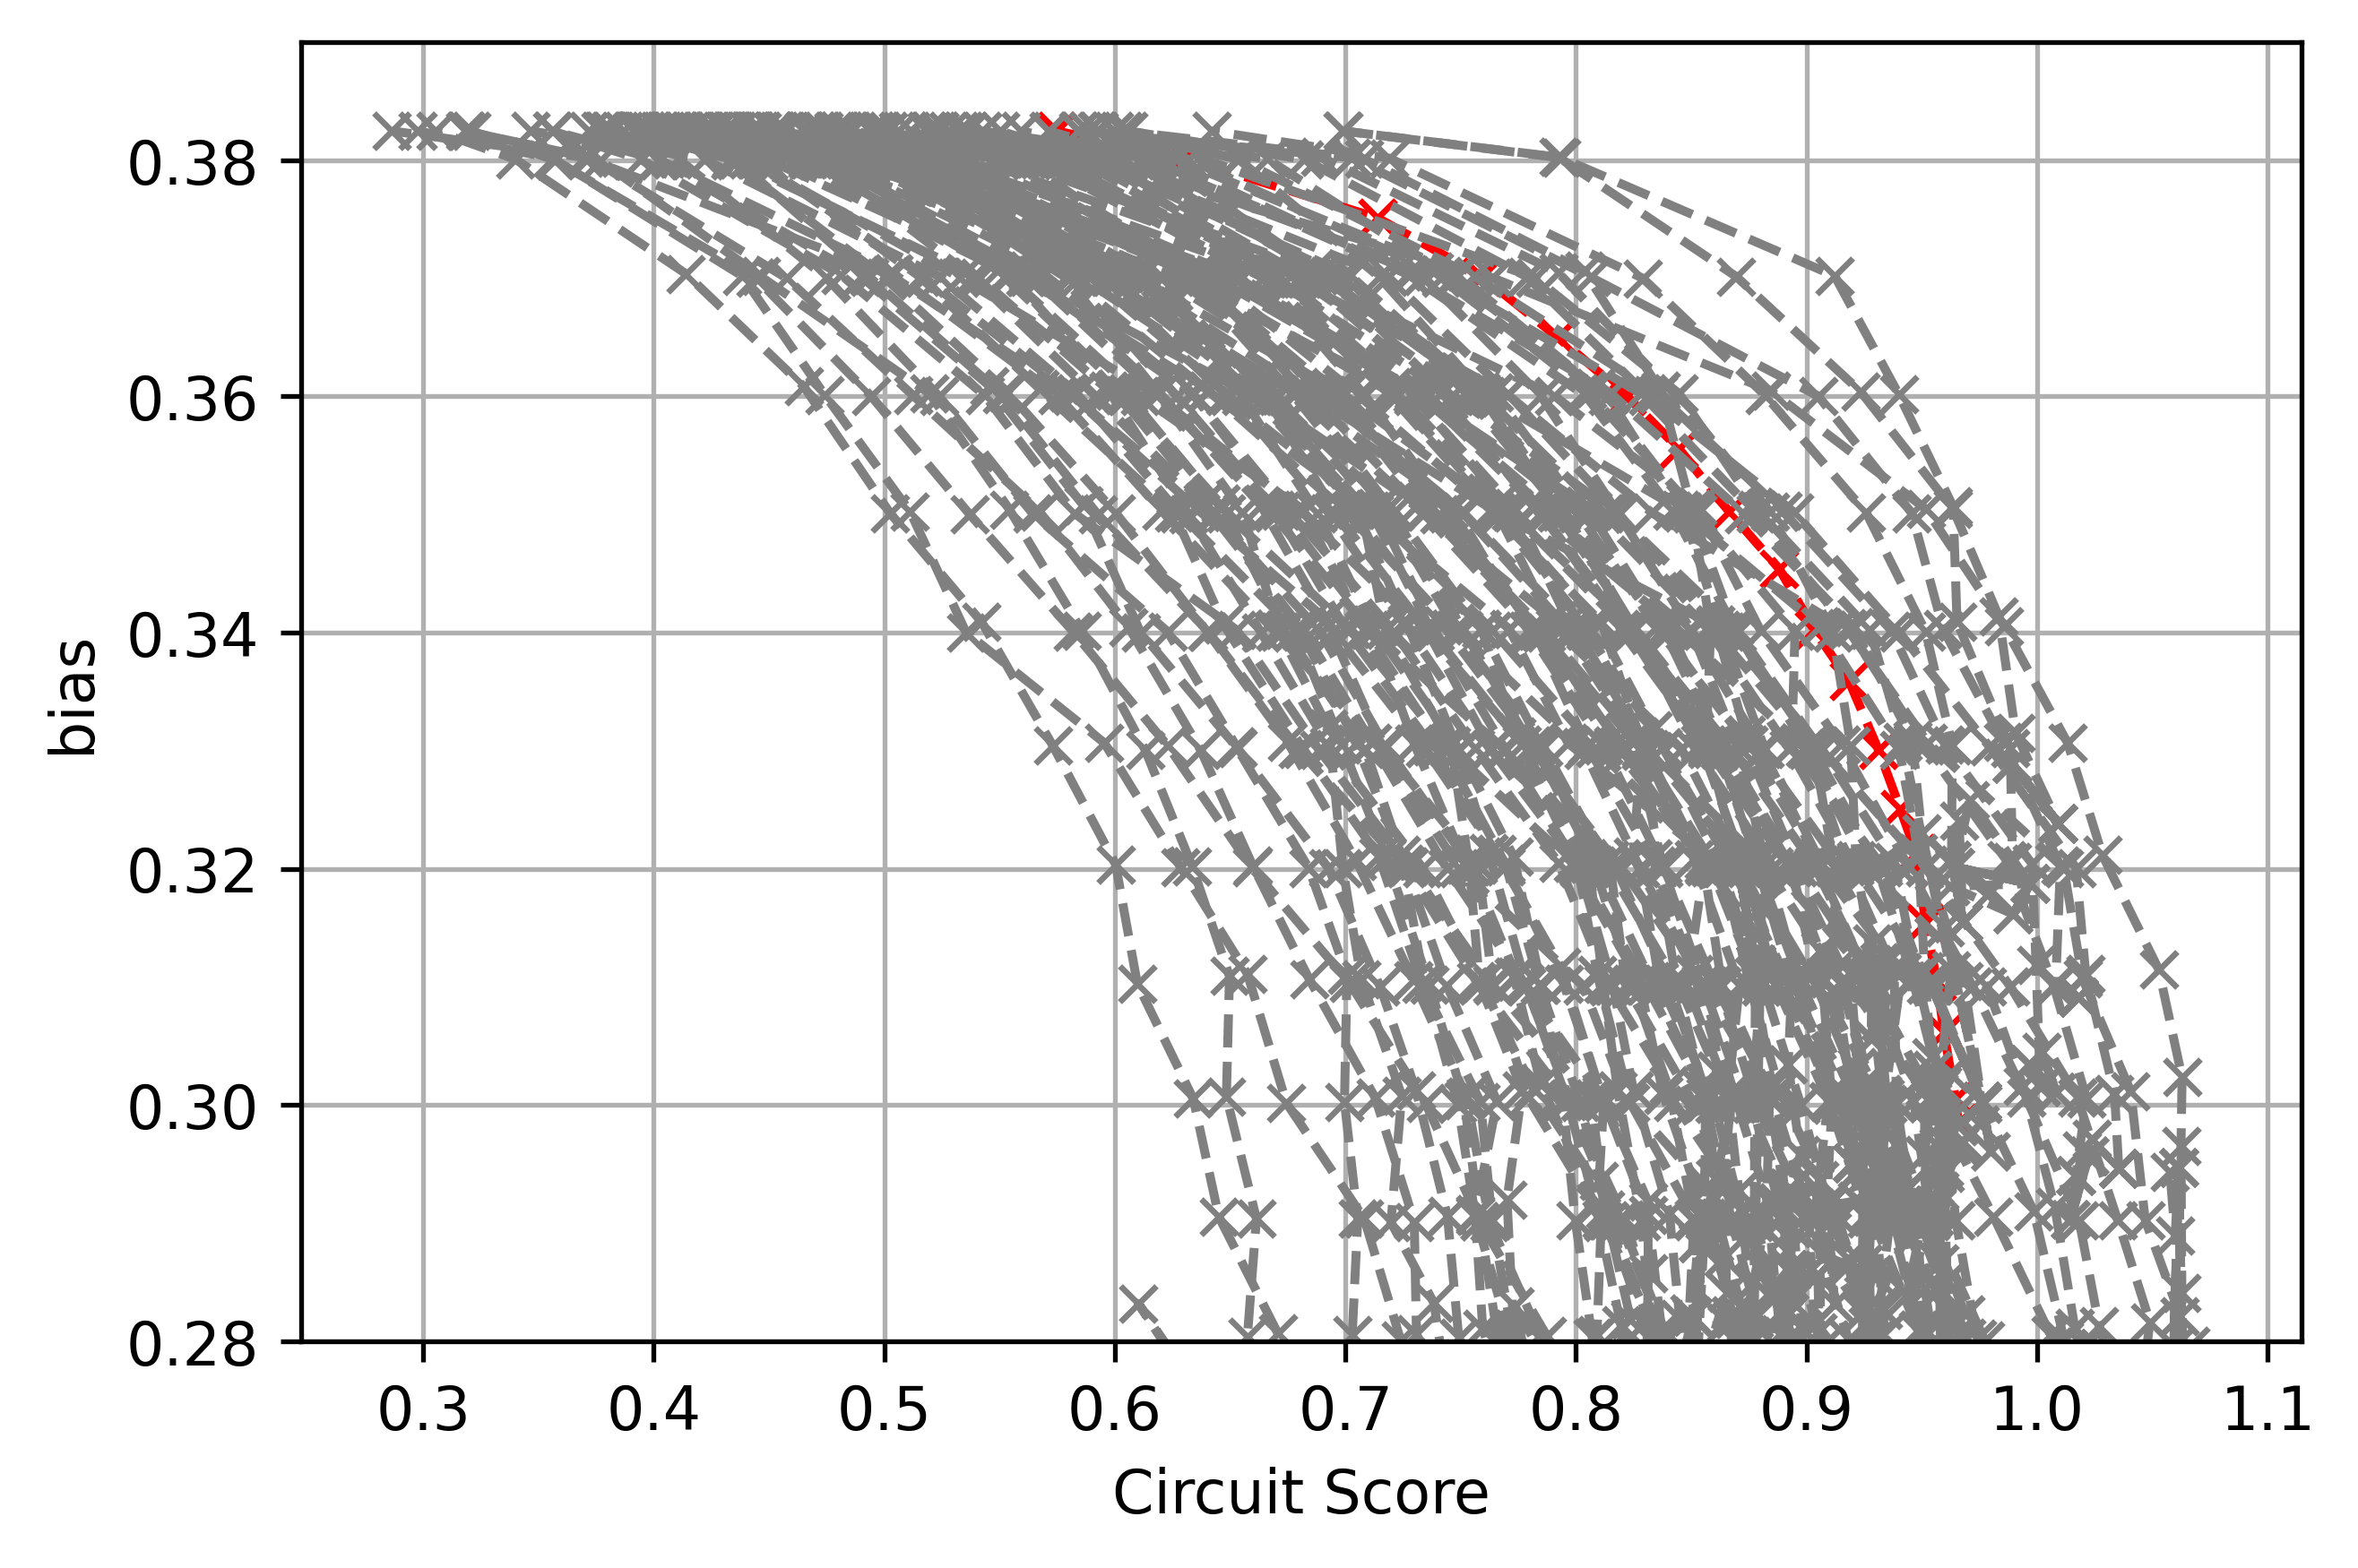

In [281]:
size = 46
biaslim_dir_cont = "../dat/Circuits/SA/biaslims/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.{}.txt".format(size), names=["size", "bias"])

plt.figure(dpi=480)
plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["Bias"].values, marker="x", color="red",
             ls = "--", label="bias")

for i in range(1,99):
    Sib_BiasDF = pd.read_csv("../dat/Unionize_bias/SubSampleSib/cont.bias.{}.{}.csv".format(1, i),
                            index_col="STR")
    ASD_cont_Dir = "../dat/Circuits/SA/SubSib_ScoreDistance_Aug17/dat_con.bias.1.{}/".format(i)
    COHES55, CutBias55, RealBias55, STRS55 = XXXX_cont(Sib_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                  ASD_cont_Dir, adj_mat, ProbMat1, ProbMat2)
    Sib_DF55 = pd.DataFrame(data={"Cohe":COHES55, "minBias":CutBias55, "Bias":RealBias55})
    plt.plot(Sib_DF55["Cohe"].values, Sib_DF55["Bias"].values, marker="x", color="gray",
             ls = "--")
plt.grid(True)
plt.ylim((0.28, 0.39))
#plt.legend()
plt.xlabel("Circuit Score")
plt.ylabel("bias")
plt.savefig("../figs/ASD_Circuits.Pareto.46.cont.pdf")

#### Same Number of swapped STRs

In [411]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)
def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES
def LoadSA3(fname, DIR, adj_mat, ProbMat1, ProbMat2, topL=100):
    fin = open(DIR+fname, 'rt')
    max_cohe, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        cohe = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
        if cohe > max_cohe:
            max_cohe = cohe
            max_bias = bias
            max_STRs = STRs
    return max_cohe, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat, ProbMat1, ProbMat2):
    COHES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        #print(row["fname"], DIR)
        try:
            fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
            #cohe, real_minbias, STRs = LoadSA2(fil, DIR)
            cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
            score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)
        except:
            print("Missing Data: {}".format(row))
            continue
        if cohe == 0:
            continue
        #COHES.append(cohe)
        COHES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return COHES, CutBias, RealBias, STRS

def XXXX_cont(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    COHES, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, ProbMat1, ProbMat2)
    New_RealBias = []
    for STRSET in STRS:
        xx = BiasDF.loc[STRSET, "EFFECT"].mean()
        #print(xx)
        New_RealBias.append(xx)
    #print(len(COHES), len(CutBias), len(New_RealBias), len(STRS))
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    COHES.append(score)
    CutBias.append(bias)
    New_RealBias.append(bias)
    STRS.append(topNSTRs)    
    #print(len(COHES), len(CutBias), len(New_RealBias), len(STRS))
    return COHES, CutBias, New_RealBias, STRS

def search_target_swap(size, BiasDF, NSwap, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        NDiff = len(set(STRs).difference(topNSTRs))
        if abs(NDiff-NSwap) < 2:

            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score > 0.714:
                #print(RegionDistributionsList(STRs))
                print(score, score1, score2)
            return bias, score, score1, score2
    return None, None, None, None

def search_target_swap2(size, BiasDF, biaslim, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        #print(round(real_minbias,3), biaslim)
        if round(real_minbias,3) == biaslim:
            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score2 > 0.673:
                #print()
                print(RegionDistributionsList(STRs))
            return bias, score, score1, score2
    return None, None, None, None

### same level of transfered bias

In [455]:
size = 46
NSwap = 5
NSwap = 0.375
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
for i in range(1, 4):
    for j in range(1, 99):
        Sib_BiasDF = pd.read_csv("../dat/Unionize_bias/SubSampleSib/cont.bias.{}.{}.csv".format(i, j),
                                index_col="STR")
        Sib_BiasDF["EFFECT"] = ASD_BiasDF["EFFECT"].values
        DIR = "../dat/Circuits/SA/SubSib_ScoreDistance_Aug17/dat_con.bias.{}.{}/".format(i, j)
        ASD_cont_Dir = "../dat/Circuits/SA/SubSib_ScoreDistance_Aug17/dat_con.bias.{}.{}/".format(i, j)
        bias, score, score1, score2 = search_target_swap2(size, Sib_BiasDF, NSwap, biaslim_df, \
                adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                ProbMat2, ProbMat2_short, ProbMat2_long, DIR)
        #print(cohe)
        if score != None:
            SCORES.append(score)
            SCORES_Short.append(score1)
            SCORES_Long.append(score2)
            Biases.append(bias)
        else:
            print(i,j)
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

Midbrain	3	Anterior_pretectal_nucleus; Midbrain_reticular_nucleus_retrorubral_area; Midbrain_reticular_nucleus
Pallidum	2	Bed_nuclei_of_the_stria_terminalis; Substantia_innominata
Hippocampus	2	Postsubiculum; Entorhinal_area_lateral_part
Amygdalar	4	Lateral_amygdalar_nucleus; Central_amygdalar_nucleus; Intercalated_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas	1	Accessory_olfactory_bulb
Striatum	4	Lateral_septal_nucleus_caudal_caudodorsal_part; Caudoputamen; Lateral_septal_nucleus_ventral_part; Nucleus_accumbens
Thalamus	16	Posterior_limiting_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Medial_geniculate_complex_medial_part; Ventral_posterolateral_nucleus_of_the_thalamus; Ventral_anterior_lateral_complex_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Anteroventral_nucleus_of_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part; Posterior_complex_of_the_thalamus; Ventral_poster

Midbrain	3	Anterior_pretectal_nucleus; Midbrain_reticular_nucleus_retrorubral_area; Midbrain_reticular_nucleus
Pallidum	2	Bed_nuclei_of_the_stria_terminalis; Substantia_innominata
Hippocampus	2	Postsubiculum; Entorhinal_area_lateral_part
Amygdalar	4	Lateral_amygdalar_nucleus; Central_amygdalar_nucleus; Intercalated_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Olfactory_areas	1	Accessory_olfactory_bulb
Striatum	4	Lateral_septal_nucleus_caudal_caudodorsal_part; Caudoputamen; Lateral_septal_nucleus_ventral_part; Nucleus_accumbens
Thalamus	16	Posterior_limiting_nucleus_of_the_thalamus; Lateral_dorsal_nucleus_of_thalamus; Medial_geniculate_complex_medial_part; Ventral_posterolateral_nucleus_of_the_thalamus; Ventral_anterior_lateral_complex_of_the_thalamus; Central_lateral_nucleus_of_the_thalamus; Anteroventral_nucleus_of_thalamus; Lateral_posterior_nucleus_of_the_thalamus; Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part; Posterior_complex_of_the_thalamus; Ventral_poster

Midbrain	3	Anterior_pretectal_nucleus; Superior_colliculus_motor_related; Nucleus_of_the_optic_tract
Pallidum	1	Medial_septal_nucleus
Hippocampus	5	Presubiculum; Postsubiculum; Subiculum_ventral_part; Subiculum_dorsal_part; Entorhinal_area_lateral_part
Amygdalar	1	Lateral_amygdalar_nucleus
Striatum	1	Caudoputamen
Thalamus	11	Parataenial_nucleus; Rhomboid_nucleus; Ventral_anterior_lateral_complex_of_the_thalamus; Anteromedial_nucleus_dorsal_part; Nucleus_of_reuniens; Lateral_dorsal_nucleus_of_thalamus; Mediodorsal_nucleus_of_thalamus; Central_lateral_nucleus_of_the_thalamus; Subparafascicular_area; Ventral_medial_nucleus_of_the_thalamus; Reticular_nucleus_of_the_thalamus
Isocortex	23	Primary_somatosensory_area_barrel_field; Primary_somatosensory_area_mouth; Primary_somatosensory_area_nose; Retrosplenial_area_ventral_part; Supplemental_somatosensory_area; Primary_somatosensory_area_upper_limb; Primary_somatosensory_area_trunk; Retrosplenial_area_dorsal_part; Anterior_cingulate_area_ventr

3 89
(1.4336210850065771, 0.08304498269896199)
(0.5148939541730301, 0.31833910034602075)
(1.7382608671269721, 0.0692041522491349)


In [456]:
print(len(SCORES))

288


<AxesSubplot:title={'center':'Info Per Edge Inside Circuit'}, xlabel='Normed Score'>

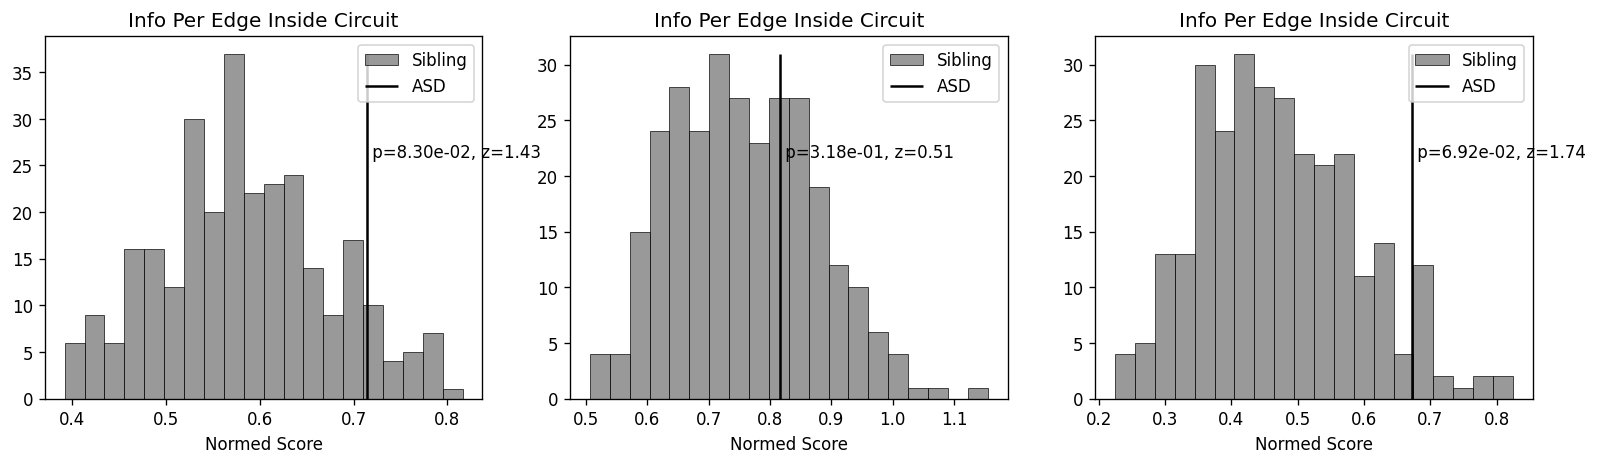

In [457]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,dpi=120, figsize=(16,4))
PlotPermutationP(SCORES, Score_ASD, ax1,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Short, Score_ASD_Short, ax2,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Long, Score_ASD_Long, ax3,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")

### Same fraction of swapped STRs

In [458]:
def search_target_swap(size, BiasDF, NSwap, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        NDiff = len(set(STRs).difference(topNSTRs))
        if abs(NDiff-NSwap) < 2:

            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            #if score > 0.714:
                #print(RegionDistributionsList(STRs))
                #print(score, score1, score2)
            return bias, score, score1, score2
    return None, None, None, None

In [459]:
size = 46
NSwap = 5
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
for i in range(1, 4):
    for j in range(1, 99):
        Sib_BiasDF = pd.read_csv("../dat/Unionize_bias/SubSampleSib/cont.bias.{}.{}.csv".format(i, j),
                                index_col="STR")
        Sib_BiasDF["EFFECT"] = ASD_BiasDF["EFFECT"].values
        DIR = "../dat/Circuits/SA/SubSib_ScoreDistance_Aug17/dat_con.bias.{}.{}/".format(i, j)
        ASD_cont_Dir = "../dat/Circuits/SA/SubSib_ScoreDistance_Aug17/dat_con.bias.{}.{}/".format(i, j)
        bias, score, score1, score2 = search_target_swap(size, Sib_BiasDF, NSwap, biaslim_df, \
                adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                ProbMat2, ProbMat2_short, ProbMat2_long, DIR)
        #print(cohe)
        if score != None:
            SCORES.append(score)
            SCORES_Short.append(score1)
            SCORES_Long.append(score2)
            Biases.append(bias)
        else:
            print(i,j)
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

1 2
1 3
0.7381580580061957 0.808322630276064 0.6884870984290118
0.8465221330734916 0.9998306964839281 0.633377201957827
1 22
1 28
1 38
1 54
0.7935816366437057 0.9870163436173889 0.6845919905694099
0.7825207623123909 0.9639401311691557 0.5644315210271308
1 85
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
2 23
2 24
2 25
2 26
2 27
2 28
2 29
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
2 84
2 85
2 86
2 87
2 88
2 89
2 90
2 91
2 92
2 93
2 94
2 95
2 96
2 97
2 98
3 6
3 10
3 19
0.7706461263853023 0.7775508628447276 0.7651654170292941
0.7313718812501142 0.8889803350716448 0.534361313973201
3 39
3 41
3 42
3 51
0.8163288440860392 1.0051591191545655 0.7410519101060185
(1.7621384562545257, 0.04371584699453557)
(0.71439380314

182


<AxesSubplot:title={'center':'Info Per Edge Inside Circuit'}, xlabel='Normed Score'>

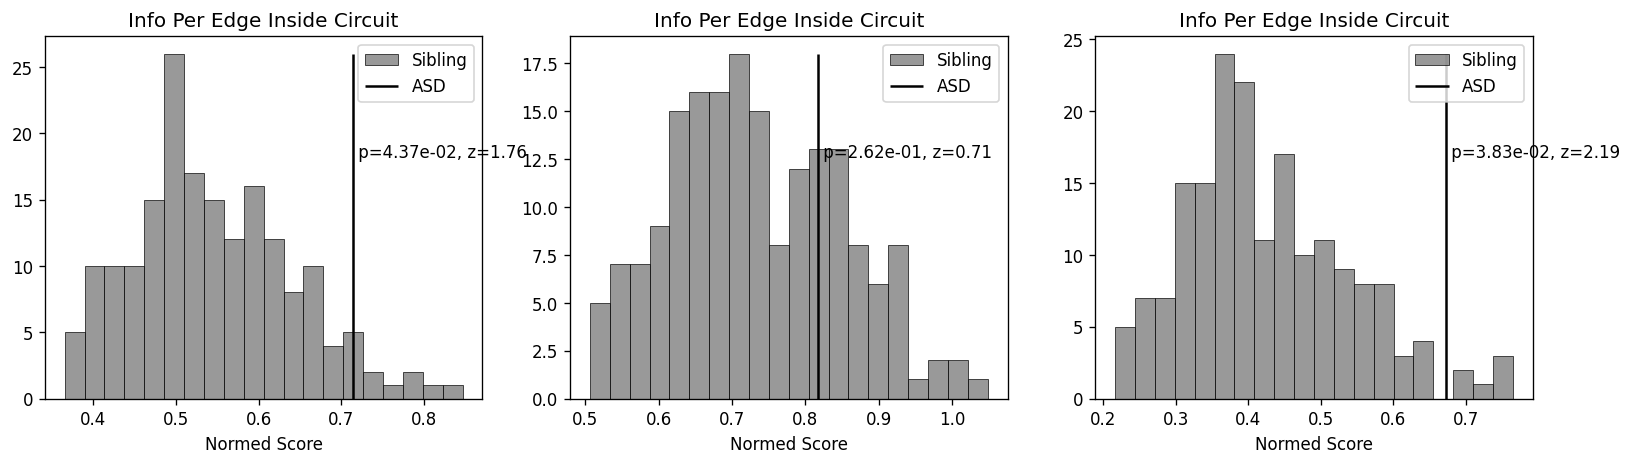

In [460]:
print(len(SCORES))
fig, (ax1, ax2, ax3) = plt.subplots(1,3,dpi=120, figsize=(16,4))
PlotPermutationP(SCORES, Score_ASD, ax1,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Short, Score_ASD_Short, ax2,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Long, Score_ASD_Long, ax3,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")

### Bias matched 

In [454]:
size = 46
NSwap = 5
NSwap = 0.375
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_ScoreDistance_Aug29/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib_biaslim/xx/"

counts = 0
for i, file in enumerate(os.listdir(SIB_BIAS_DIR)):
    if not file.startswith("cont.bias."):
        continue
    
    try:
        name = file.rstrip(".csv")

        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR + file, index_col="STR")
        # Sib_BiasDF["EFFECT"] = ASD_BiasDF["EFFECT"].values
        DIR = SIB_SA_DIR + name + "/"
        bias, score, score1, score2 = search_target_swap2(size, Sib_BiasDF, NSwap, biaslim_df, \
                adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                ProbMat2, ProbMat2_short, ProbMat2_long, DIR)
        if score2 > Score_ASD_Long:
            print("--" + file)
        #print(cohe)
        if score != None:
            SCORES.append(score)
            SCORES_Short.append(score1)
            SCORES_Long.append(score2)
            Biases.append(bias)
        else:
            print(file)
    except:
        continue
        
    counts += 1
    if counts > 100 :
        break
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

Midbrain	2	Anterior_pretectal_nucleus; Nucleus_of_the_optic_tract
Hippocampus	4	Field_CA3; Field_CA1; Field_CA2; Subiculum_dorsal_part
Striatum	1	Lateral_septal_nucleus_caudal_caudodorsal_part
Thalamus	29	Lateral_dorsal_nucleus_of_thalamus; Medial_geniculate_complex_dorsal_part; Dorsal_part_of_the_lateral_geniculate_complex; Nucleus_of_reuniens; Medial_geniculate_complex_ventral_part; Lateral_posterior_nucleus_of_the_thalamus; Posterior_complex_of_the_thalamus; Rhomboid_nucleus; Ventral_posteromedial_nucleus_of_the_thalamus; Intermediodorsal_nucleus_of_the_thalamus; Anteromedial_nucleus_dorsal_part; Paraventricular_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Central_lateral_nucleus_of_the_thalamus; Ventral_anterior_lateral_complex_of_the_thalamus; Posterior_limiting_nucleus_of_the_thalamus; Ventral_posterolateral_nucleus_of_the_thalamus; Medial_geniculate_complex_medial_part; Central_medial_nucleus_of_the_thalamus; Parataenial_nucleus; Anteroventral_nucleus_of_thalamus; A

Medulla	21	Gigantocellular_reticular_nucleus; Paragigantocellular_reticular_nucleus_dorsal_part; Intermediate_reticular_nucleus; Hypoglossal_nucleus; Superior_vestibular_nucleus; Lateral_reticular_nucleus; Medullary_reticular_nucleus_ventral_part; Spinal_nucleus_of_the_trigeminal_oral_part; Nucleus_prepositus; Facial_motor_nucleus; Nucleus_raphe_magnus; Parvicellular_reticular_nucleus; Lateral_vestibular_nucleus; Spinal_nucleus_of_the_trigeminal_interpolar_part; Spinal_nucleus_of_the_trigeminal_caudal_part; Nucleus_of_the_solitary_tract; Medial_vestibular_nucleus; Spinal_vestibular_nucleus; Magnocellular_reticular_nucleus; Nucleus_ambiguus; Paragigantocellular_reticular_nucleus_lateral_part
Midbrain	10	Cuneiform_nucleus; Red_nucleus; Midbrain_reticular_nucleus; Inferior_colliculus_external_nucleus; Dorsal_nucleus_raphe; Pedunculopontine_nucleus; Superior_colliculus_motor_related; Midbrain_reticular_nucleus_retrorubral_area; Periaqueductal_gray; Ventral_tegmental_area
Cerebellum	3	Inter

Medulla	1	Nucleus_raphe_magnus
Midbrain	13	Periaqueductal_gray; Medial_pretectal_area; Anterior_pretectal_nucleus; Midbrain_reticular_nucleus; Superior_colliculus_motor_related; Central_linear_nucleus_raphe; Dorsal_nucleus_raphe; Nucleus_of_the_posterior_commissure; Inferior_colliculus_external_nucleus; Pedunculopontine_nucleus; Interpeduncular_nucleus; Ventral_tegmental_area; Cuneiform_nucleus
Pallidum	2	Medial_septal_nucleus; Triangular_nucleus_of_septum
Pons	5	Nucleus_incertus; Parabrachial_nucleus; Pontine_reticular_nucleus_caudal_part; Pontine_central_gray; Superior_central_nucleus_raphe
Hypothalamus	9	Dorsal_premammillary_nucleus; Medial_mammillary_nucleus; Posterior_hypothalamic_nucleus; Supramammillary_nucleus; Paraventricular_hypothalamic_nucleus; Lateral_hypothalamic_area; Subparaventricular_zone; Subthalamic_nucleus; Dorsomedial_nucleus_of_the_hypothalamus
Thalamus	16	Subparafascicular_area; Intermediodorsal_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the

Medulla	22	Spinal_nucleus_of_the_trigeminal_interpolar_part; Facial_motor_nucleus; Paragigantocellular_reticular_nucleus_lateral_part; Superior_vestibular_nucleus; Parvicellular_reticular_nucleus; Intermediate_reticular_nucleus; Lateral_vestibular_nucleus; Spinal_nucleus_of_the_trigeminal_oral_part; Spinal_vestibular_nucleus; Medullary_reticular_nucleus_dorsal_part; Lateral_reticular_nucleus; Hypoglossal_nucleus; Dorsal_cochlear_nucleus; Nucleus_raphe_magnus; Nucleus_ambiguus; Magnocellular_reticular_nucleus; Gigantocellular_reticular_nucleus; Medial_vestibular_nucleus; Spinal_nucleus_of_the_trigeminal_caudal_part; Nucleus_of_the_solitary_tract; Medullary_reticular_nucleus_ventral_part; Nucleus_prepositus
Midbrain	8	Inferior_colliculus_external_nucleus; Cuneiform_nucleus; Pedunculopontine_nucleus; Midbrain_reticular_nucleus_retrorubral_area; Midbrain_reticular_nucleus; Red_nucleus; Superior_colliculus_motor_related; Periaqueductal_gray
Cerebellum	6	Central_lobule; Dentate_nucleus; Simp

<AxesSubplot:title={'center':'Info Per Edge Inside Circuit'}, xlabel='Normed Score'>

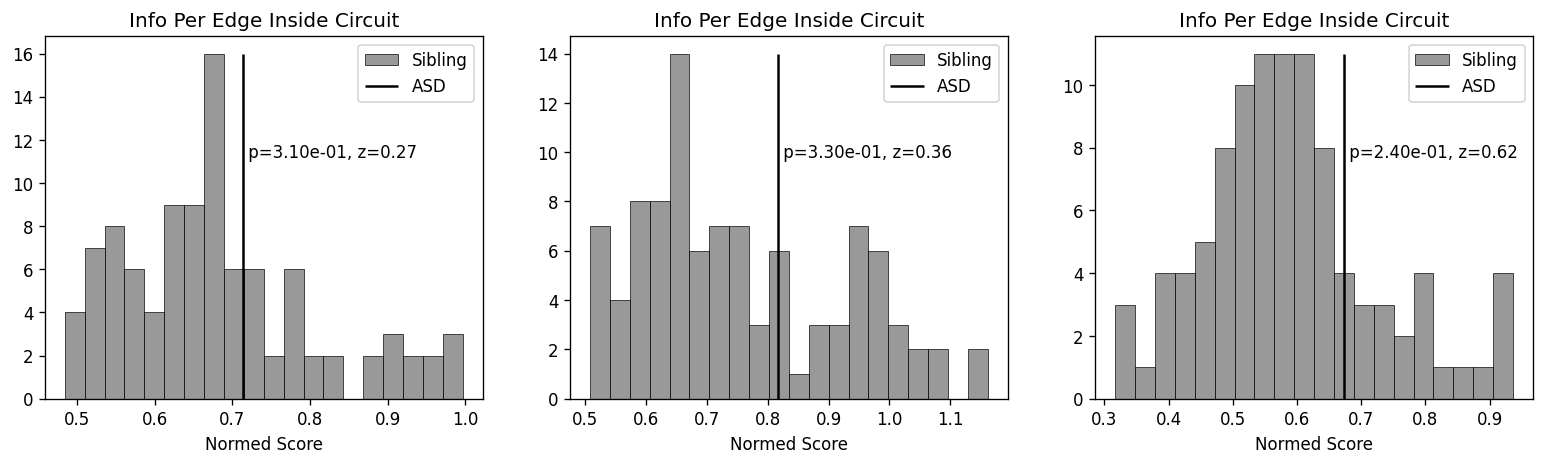

In [413]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,dpi=120, figsize=(16,4))
PlotPermutationP(SCORES, Score_ASD, ax1,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Short, Score_ASD_Short, ax2,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Long, Score_ASD_Long, ax3,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")

In [461]:
size = 46
NSwap = 5
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_ScoreDistance_Aug29/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib_biaslim/xx/"

counts = 0
for i, file in enumerate(os.listdir(SIB_BIAS_DIR)):
    if not file.startswith("cont.bias."):
        continue
    
    try:
        name = file.rstrip(".csv")

        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR + file, index_col="STR")
        # Sib_BiasDF["EFFECT"] = ASD_BiasDF["EFFECT"].values
        DIR = SIB_SA_DIR + name + "/"
        bias, score, score1, score2 = search_target_swap(size, Sib_BiasDF, NSwap, biaslim_df, \
                adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                ProbMat2, ProbMat2_short, ProbMat2_long, DIR)
        if score2 > Score_ASD_Long:
            print("--" + file)
        #print(cohe)
        if score != None:
            SCORES.append(score)
            SCORES_Short.append(score1)
            SCORES_Long.append(score2)
            Biases.append(bias)
        else:
            print(file)
    except:
        continue
        
    counts += 1
    if counts > 100 :
        break
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

--cont.bias.21.965.csv
0.7289302275033405 0.9283040932096799 0.49296242442052113
0.8065677097962315 1.0061043762186241 0.6215225331140126
0.8756379113899854 0.968539954475625 0.7281559179915328
--cont.bias.21.6862.csv
0.7410349275930544 0.8914974237934038 0.564336323861972
0.8304947078597138 0.9616438571333903 0.6422571053727899
0.7278978704589028 0.7810929750417951 0.634664961096866
--cont.bias.12.6150.csv
0.9501577987966996 1.0054522443966598 0.8325526939556965
--cont.bias.14.3778.csv
0.969060720129119 1.0020040141070121 0.9127466600046052
--cont.bias.22.9179.csv
0.9070716641785768 0.9535361770622554 0.8125075235883339
--cont.bias.22.2792.csv
0.9020035910539418 1.0484764416198449 0.7535359740406432
--cont.bias.14.7212.csv
0.8555999895245142 0.9392928637467252 0.704544558001499
--cont.bias.19.88.csv
0.717585877107208 0.8892149878599596 0.46117612128381996
0.7285467849875042 0.913657932026782 0.501636346681293
0.7693851544865153 0.7952347709919128 0.729337349605001
--cont.bias.17.4329.

<AxesSubplot:title={'center':'Info Per Edge Inside Circuit'}, xlabel='Normed Score'>

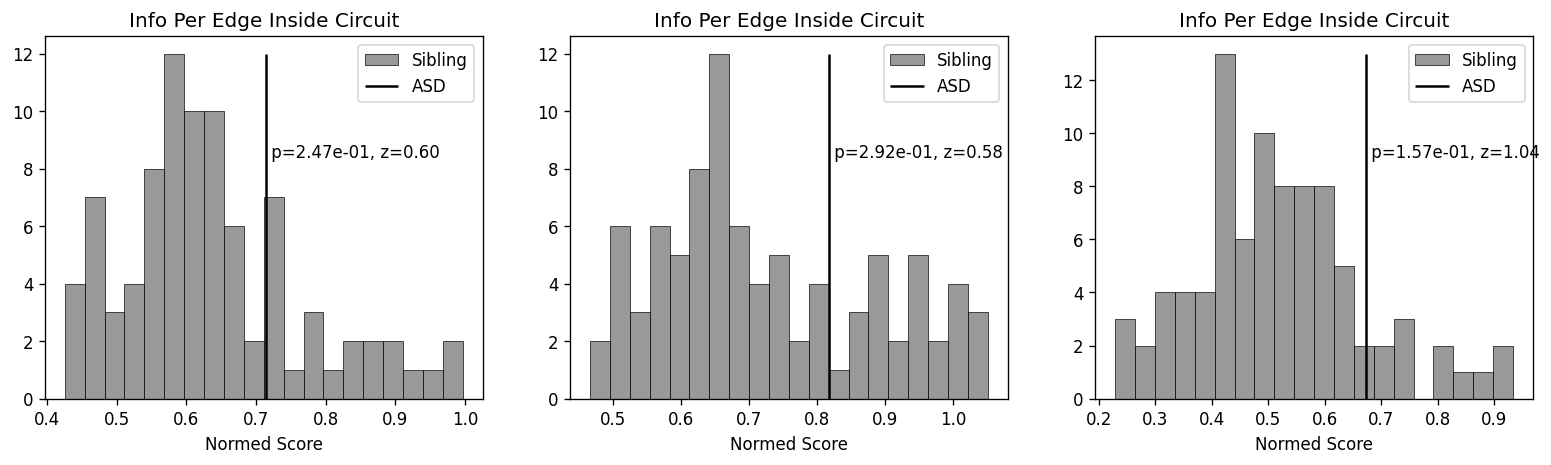

In [462]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,dpi=120, figsize=(16,4))
PlotPermutationP(SCORES, Score_ASD, ax1,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Short, Score_ASD_Short, ax2,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")
PlotPermutationP(SCORES_Long, Score_ASD_Long, ax3,
                     title="Info Per Edge Inside Circuit".format(), xlabel="Normed Score", 
                     dist_label="Sibling", bar_label="ASD")

(18, 3)
(18, 3)
(18, 3)
(17, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(17, 3)
(18, 3)
(18, 3)
(17, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(15, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(17, 3)
(18, 3)
(18, 3)
(18, 3)
(15, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(15, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)
(18, 3)


Text(0, 0.5, 'bias')

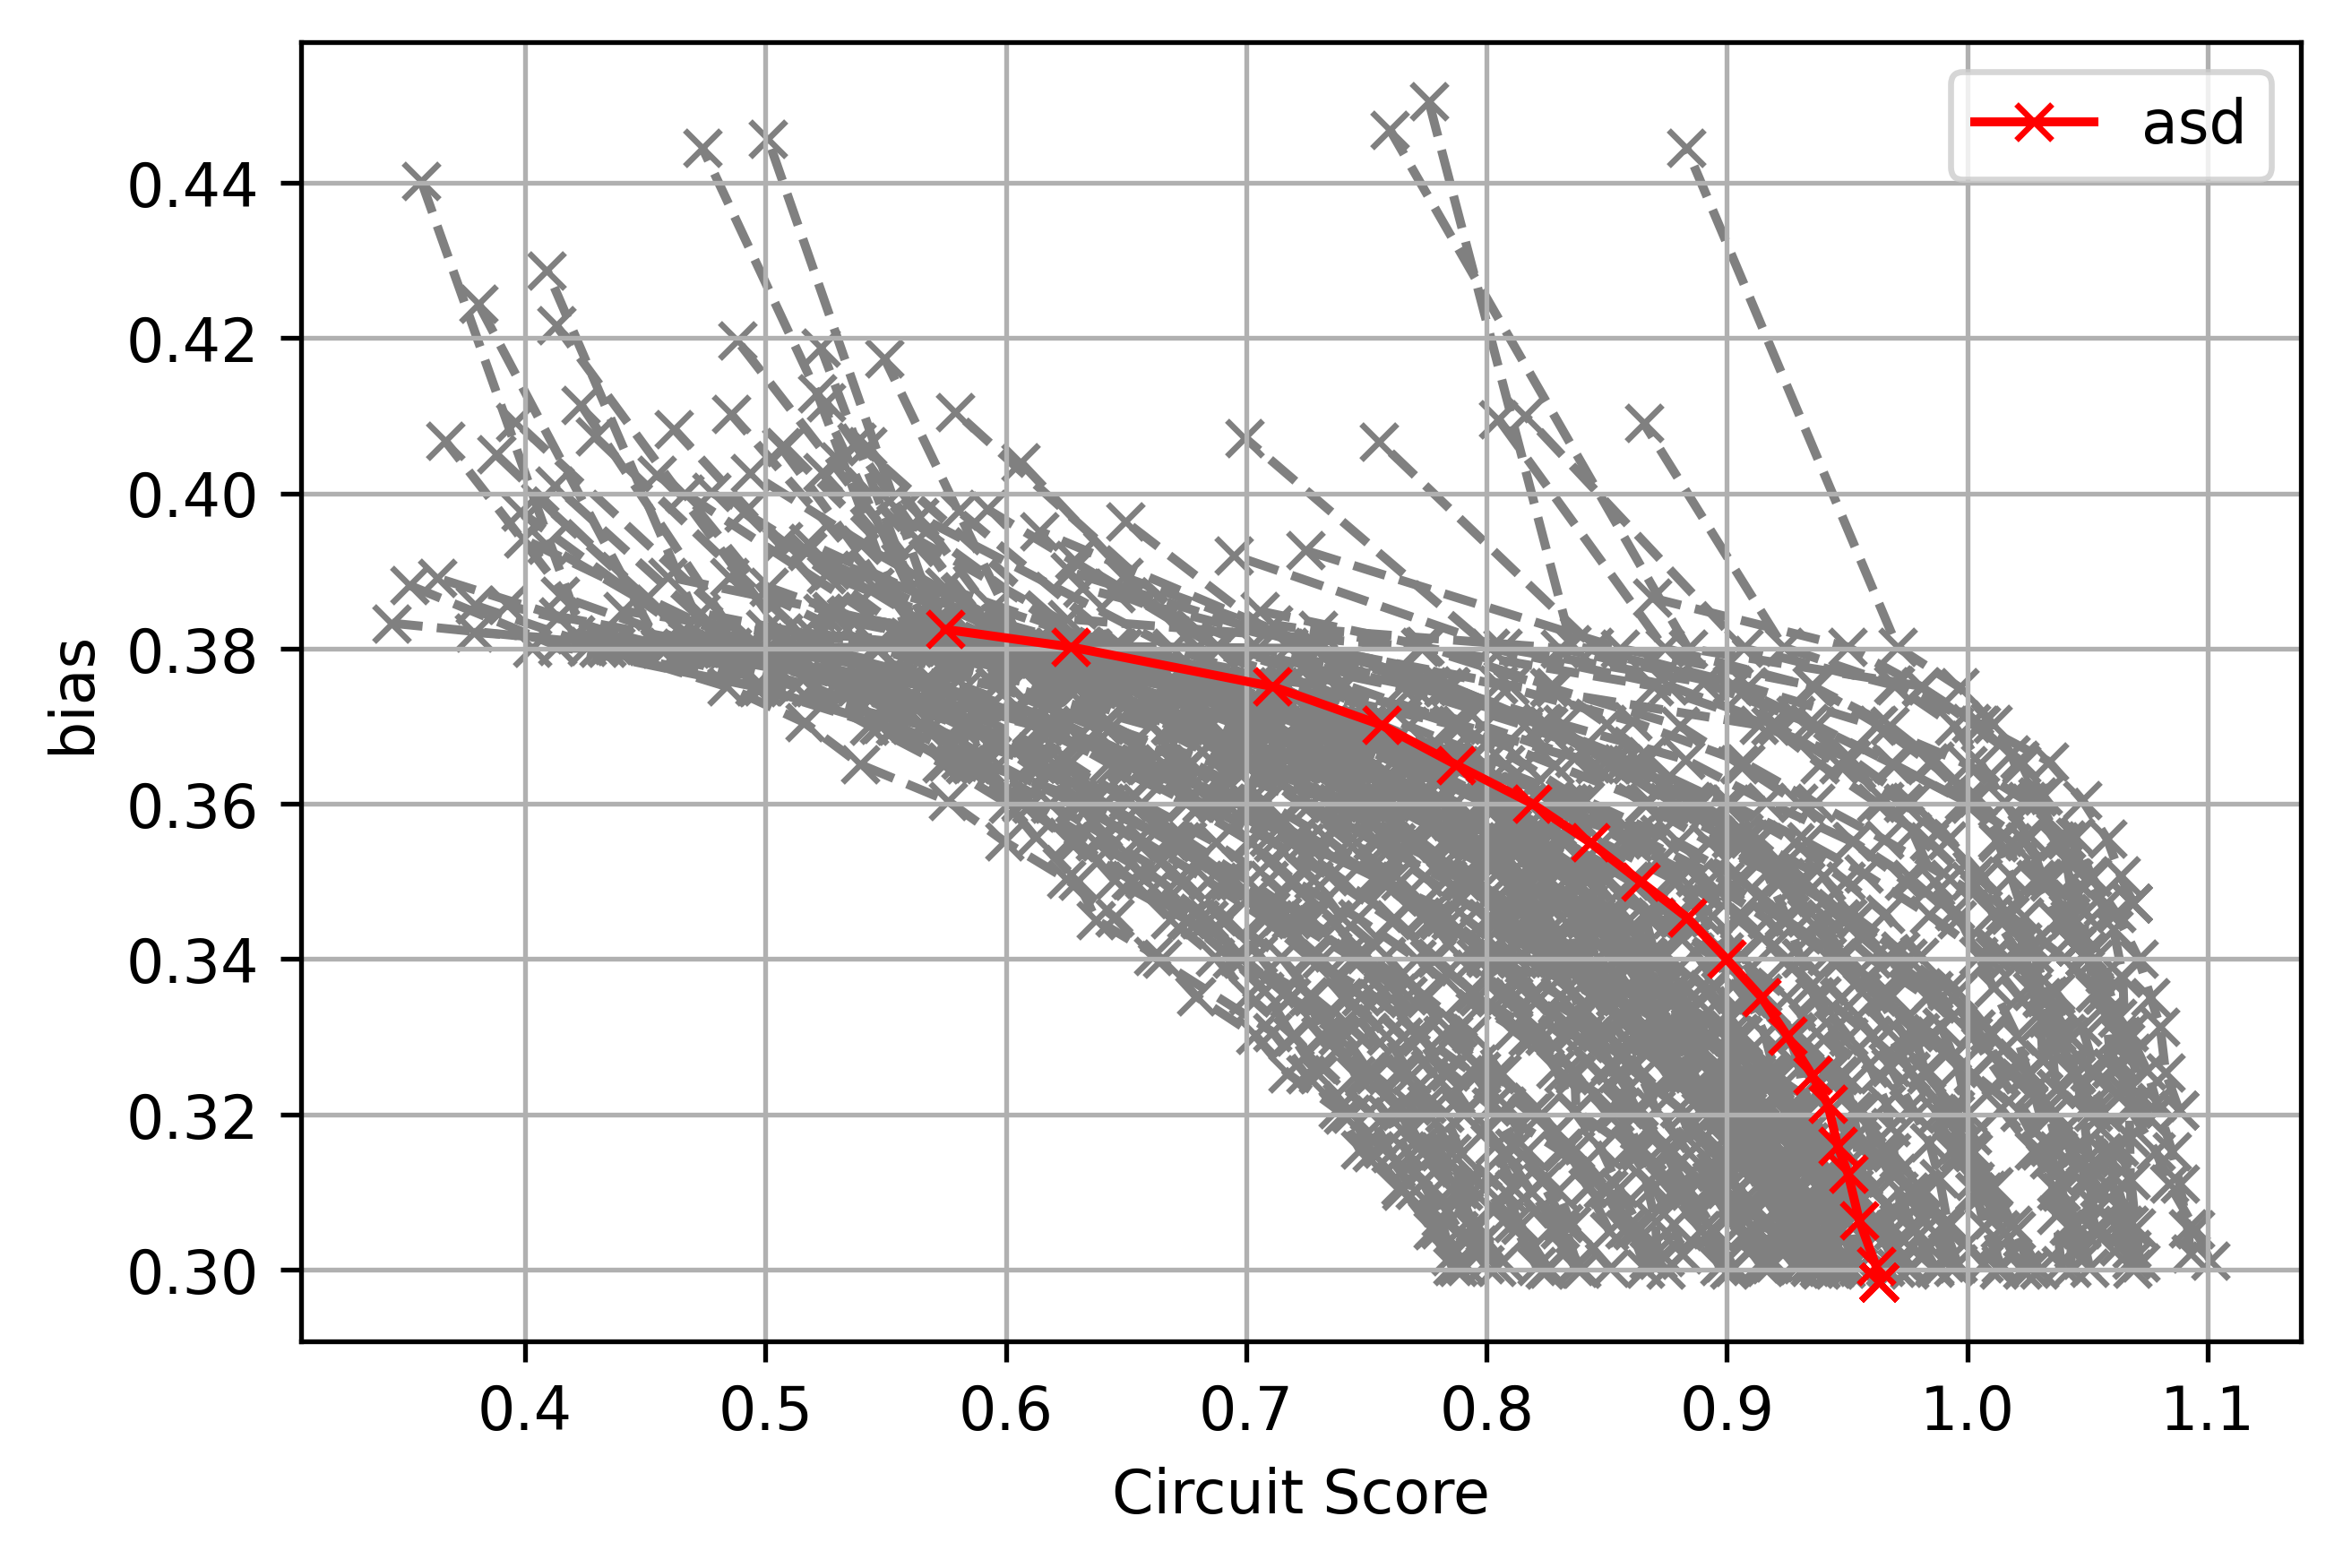

In [453]:
plt.figure(dpi=480)
plt.plot(ASD_DF55["Cohe"].values, ASD_DF55["Bias"].values, marker="x", color="red", label="asd", zorder=100)
size = 46

count = 0
for i, file in enumerate(os.listdir(SIB_BIAS_DIR)):
    if not file.startswith("cont.bias."):
        continue
    
    try:
        name = file.rstrip(".csv")

        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR + file, index_col="STR")
        # Sib_BiasDF["EFFECT"] = ASD_BiasDF["EFFECT"].values
        DIR = SIB_SA_DIR + name + "/"
        #print(DIR)
        _COHES55, _CutBias55, _RealBias55, _STRS55 = XXXX(Sib_BiasDF, Sib_BiasDF, biaslim_df, size, 
                                                  DIR, adj_mat, ProbMat1, ProbMat2)
        Sib_DF55 = pd.DataFrame(data={"Cohe":_COHES55, "minBias":_CutBias55, "Bias":_RealBias55})
        Sib_DF55 = Sib_DF55.sort_values("Bias")
        #print(Sib_DF55)
        if Sib_DF55.shape[0] > 10:
            plt.plot(Sib_DF55["Cohe"].values, Sib_DF55["Bias"].values, marker="x", color="grey", zorder=1,
                     ls = "--")
            print(Sib_DF55.shape)
            count += 1
            if count > 100:
                break
        plt.grid(True)

            
    except:
        continue
#plt.ylim((0.28, 0.39))
plt.legend()
plt.xlabel("Circuit Score")
plt.ylabel("bias")
#plt.savefig("../figs/ASD_Circuits.Pareto.46.pdf")

In [447]:
Sib_DF55.shape

(18, 3)

In [448]:
Sib_DF55

,Cohe,minBias,Bias
0,0.434007,0.38000,0.380060
1,0.495256,0.37500,0.375099
2,0.547031,0.37000,0.370121
3,0.582903,0.36500,0.365103
4,0.610575,0.36000,0.360065
5,0.636860,0.35500,0.355132
6,0.664076,0.35000,0.350131
7,0.684321,0.34500,0.345141
8,0.698133,0.34000,0.340083
9,0.718075,0.33500,0.335033


### Expression Z2 correlation and distance

In [464]:
Cartesian_distancesDF = pd.read_csv("../dat/allen-mouse-conn/Dist_CartesianDistance.csv",
                                   index_col=0)
ExpLv = pd.read_csv("../dat/ExpMat/Energy.ExpLevel.Log2.QN.csv", index_col=0)
ExpZ2 = pd.read_csv("../dat/ExpMat/Energy.ExpZ2.csv", index_col=0)

STR1 = "Nucleus_accumbens"
STR2 = "Caudoputamen"
# Expression Corr; Expression Bias Corr; ASD Expression Corr; ASD Expression Bias Corr
# Cartesian Distance
Exps_STR1 = ExpLv.loc[:, STR1]; Exps_STR2 = ExpLv.loc[:, STR2]
ExpCorr, p_ExpCorr = spearmanr(Exps_STR1, Exps_STR2, nan_policy="omit")
Exps_ASD_STR1 = ExpLv.loc[ASD_Genes_Entrez, STR1]
Exps_ASD_STR2 = ExpLv.loc[ASD_Genes_Entrez, STR2]
ExpCorr_ASD, p_ExpCorr_ASD = spearmanr(Exps_ASD_STR1, Exps_ASD_STR2, nan_policy="omit")
print(ExpCorr, p_ExpCorr)
print(ExpCorr_ASD, p_ExpCorr_ASD)

,Anterior_amygdalar_area,Anterior_cingulate_area_dorsal_part,Anterior_cingulate_area_ventral_part,Nucleus_accumbens,Anterodorsal_nucleus,Anterior_hypothalamic_nucleus,Agranular_insular_area_dorsal_part,Agranular_insular_area_posterior_part,Agranular_insular_area_ventral_part,Nucleus_ambiguus,...,Primary_visual_area,Posterolateral_visual_area,posteromedial_visual_area,Ventral_medial_nucleus_of_the_thalamus,Ventromedial_hypothalamic_nucleus,Ventral_posterolateral_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus,Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,Ventral_tegmental_area,Hypoglossal_nucleus
ROW,,,,,,,,,,,,,,,,,,,,,
Anterior_amygdalar_area,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.606233,0.0
Anterior_cingulate_area_dorsal_part,0.000000,0.0,3.878521,0.000000,0.000000,0.0,0.0,0.0,2.621566,0.000000,...,3.746798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.892409,0.0
Anterior_cingulate_area_ventral_part,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Nucleus_accumbens,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.284993,0.0
Anterodorsal_nucleus,0.000000,0.0,5.371320,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ventral_posterolateral_nucleus_of_the_thalamus,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Ventral_posteromedial_nucleus_of_the_thalamus,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [467]:
1699 * 24 * (0.02 + 0.0067) 

1088.7192

### Correlation between bias and score

#### top 46 and bias

In [470]:
Ncont = 1000
topN=46
Bias = []
All_Cont_Score = []
All_Cont_Scores_short = []
All_Cont_Scores_long = []
contDir = "../dat/Unionize_bias/SubSampleSib/"
for i, file in enumerate(os.listdir(contDir)):
    if file.startswith("cont.genes"):
        continue
    df = pd.read_csv(contDir + file, index_col="STR")
    top_strs = df.index.values[:46]
    Bias.append(df.head(46)["EFFECT"].mean())
    cont_score = ScoreCircuit_v7(top_strs, adj_mat, ProbMat1, ProbMat2)
    cont_score_short = ScoreCircuit_v7(top_strs, adj_mat, ProbMat1_short, ProbMat2_short)
    cont_score_long = ScoreCircuit_v7(top_strs, adj_mat, ProbMat1_long, ProbMat2_long)
    
    All_Cont_Score.append(cont_score)
    All_Cont_Scores_short.append(cont_score_short)
    All_Cont_Scores_long.append(cont_score_long)
    
    if i > Ncont:
        break
Bias = np.array(Bias)
All_Cont_Score = np.array(All_Cont_Score)
All_Cont_Scores_short = np.array(All_Cont_Scores_short)
All_Cont_Scores_long = np.array(All_Cont_Scores_long)

(0.22336430350989575, 8.540805128498757e-13)


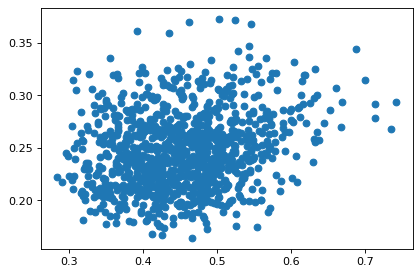

In [474]:
plt.scatter(All_Cont_Score, Bias)
print(pearsonr(All_Cont_Score, Bias))

(-0.09424128972693041, 0.00282584013590732)


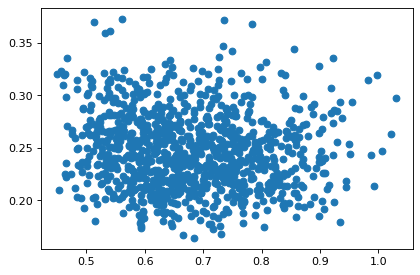

In [475]:
plt.scatter(All_Cont_Scores_short, Bias)
print(pearsonr(All_Cont_Scores_short, Bias))

(0.053685006657144034, 0.08941918034010947)


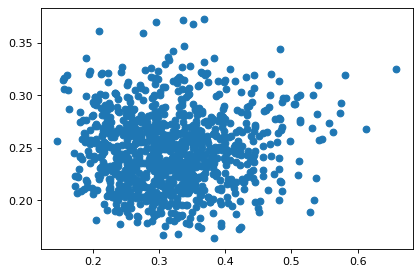

In [476]:
plt.scatter(All_Cont_Scores_long, Bias)
print(pearsonr(All_Cont_Scores_long, Bias))

#### 46 SA and bias

In [ ]:
size = 46
NSwap = 5
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_ScoreDistance_Aug29/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib_biaslim/xx/"

counts = 0
for i, file in enumerate(os.listdir(SIB_BIAS_DIR)):
    if not file.startswith("cont.bias."):
        continue
    
    try:
        name = file.rstrip(".csv")

        Sib_BiasDF = pd.read_csv(SIB_BIAS_DIR + file, index_col="STR")
        # Sib_BiasDF["EFFECT"] = ASD_BiasDF["EFFECT"].values
        DIR = SIB_SA_DIR + name + "/"
        bias, score, score1, score2 = search_target_swap(size, Sib_BiasDF, NSwap, biaslim_df, \
                adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                ProbMat2, ProbMat2_short, ProbMat2_long, DIR)
        if score2 > Score_ASD_Long:
            print("--" + file)
        #print(cohe)
        if score != None:
            SCORES.append(score)
            SCORES_Short.append(score1)
            SCORES_Long.append(score2)
            Biases.append(bias)
        else:
            print(file)
    except:
        continue
        
    counts += 1
    if counts > 100 :
        break
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

In [477]:
3401 + 1700

5101

### Case vs Cont

In [489]:
size = 46
NSwap = 5
Score_ASD = 0.714
Score_ASD_Short = 0.817 #0.817 0.673
Score_ASD_Long = 0.673

biaslim_dir_cont = "../dat/Circuits/SA/biaslims2/"
biaslim_df = pd.read_csv(biaslim_dir_cont + "biaslim.size.46.top17.txt", header=None, names=["size", "bias"])
biaslim_df = biaslim_df.sort_values("bias", ascending=False)

Biases = []
SCORES = []
SCORES_Short = []
SCORES_Long = []
SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_ScoreDistance_Sep02/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"

counts = 0
for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    d = os.path.join(SIB_SA_DIR, file)
    if os.path.isdir(d):
        #print(d)

        biasdf = SIB_BIAS_DIR + file + ".csv"
        Sib_BiasDF = pd.read_csv(biasdf, index_col="STR")
        bias, score, score1, score2 = search_target_swap(size, Sib_BiasDF, NSwap, biaslim_df, \
                adj_mat, ProbMat1, ProbMat1_short, ProbMat1_long, \
                ProbMat2, ProbMat2_short, ProbMat2_long, SIB_SA_DIR)
        #if score2 > Score_ASD_Long:
        #    print("--" + file)
        #print(cohe)
        if score != None:
            SCORES.append(score)
            SCORES_Short.append(score1)
            SCORES_Long.append(score2)
            Biases.append(bias)
        else:
            print(file)

        
    counts += 1
    if counts > 10 :
        break
#print(COHES, Score_ASD)
print(GetPermutationP(SCORES, Score_ASD))
print(GetPermutationP(SCORES_Short, Score_ASD_Short))
print(GetPermutationP(SCORES_Long, Score_ASD_Long))

IndexError: list index out of range